# FineWeb 2 Hebrew Dataset analysis

Motivation - explore a large Pre-training dataset in the Hebrew language which is considered "Low Resource language" - meaning that there aren't plenty of data available (both raw and annotated). Try to improve the filtering method for Hebrew in order to create a better starting point for training Hebrew LLMs.

FineWeb 2 is a "Pre-training" dataset containing text from various sources on the Internet. The data in the dataset was selected by employing various Filtering and De-duplication methods and schemes whose efficacy was measured using training and evaluation of hundreds of "Ablation models" and eventually the most performance enhancing data pipeline was selected and applied to the entire raw data for the final dataset creation.   

## Ideas:

* Download a sample of the data (unfiltered data is over 20GB in size)
* Go over the dataset features meaning.
* Emphasize the importance of tokenization by Creating word clouds using different tokenizers:
  * A naive Hebrew tokenizer (split by delimiters)
  * A pretrained tokenizer from Huggingface (GPT/Llama/Gemma/etc...)
  * Train a BPE tokenizer on the dataset corpus
* Try to do some clustering on the metadata of the dataset
* Try to do some clustering using Bag of words, TFIDF, LDA.
* Try to train BERT and beat AlephBERT on some task

Done:
* Plotted Distributions of:
  * Character count in documents
  * Document count in websites
  * Document count in CC dumps
  * Document count per Crawl day
  * Word count in corpus (after very basic tokenization)
  * Remove diacritics
  * Documents with/without niqqud
* TODO:
* Train LDA - grid-search the number of topics/hyperparams using Coherence Measures
* https://radimrehurek.com/gensim/

https://gemini.google.com/u/1/gem/brainstormer/ea34c88fd115febf

* compare Stop Word lists from https://github.com/NNLP-IL/Stop-Words-Hebrew to the rank of the words extracted by the naive tokenizer

# Install dependencies and download assets

In [10]:
!pip install polars wordcloud matplotlib datasets  python-bidi pyconll seaborn matplotlib numpy tqdm networkx gensim tokenizers pyarrow transformers torch huggingface_hub["cli"] pyldavis

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 2.6/2.6 MB 5.9 MB/s eta 0:00:00 MB/s eta 0:00:01:010m
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 13.5/13.5 MB 20.8 MB/s eta 0:00:00m eta 0:00:010:00:01
  Using cached joblib-1.4.2-py3-none-any.whl (301 kB)
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 397.3/397.3 KB 18.3 MB/s eta 0:00:00


In [4]:
!wget https://github.com/opensourcedesign/fonts/raw/refs/heads/master/gnu-freefont_freesans/FreeSansBold.ttf

--2025-03-15 10:12:40--  https://github.com/opensourcedesign/fonts/raw/refs/heads/master/gnu-freefont_freesans/FreeSansBold.ttf
Resolving github.com (github.com)... 20.217.135.5
Connecting to github.com (github.com)|20.217.135.5|:443... connected.
HTTP request sent, awaiting response... 302 Found
Location: https://raw.githubusercontent.com/opensourcedesign/fonts/refs/heads/master/gnu-freefont_freesans/FreeSansBold.ttf [following]
--2025-03-15 10:12:40--  https://raw.githubusercontent.com/opensourcedesign/fonts/refs/heads/master/gnu-freefont_freesans/FreeSansBold.ttf
Resolving raw.githubusercontent.com (raw.githubusercontent.com)... 185.199.109.133, 185.199.110.133, 185.199.111.133, ...
Connecting to raw.githubusercontent.com (raw.githubusercontent.com)|185.199.109.133|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 359272 (351K) [application/octet-stream]
Saving to: ‘FreeSansBold.ttf’

FreeSansBold.ttf    100%[===================>] 350.85K  1.76MB/s    in 0.2s

In [5]:
!wget https://huggingface.co/datasets/HuggingFaceFW/fineweb-2/resolve/main/data/heb_Hebr/train/000_00000.parquet -O fineweb2_heb_000.parquet

--2025-03-15 10:12:48--  https://huggingface.co/datasets/HuggingFaceFW/fineweb-2/resolve/main/data/heb_Hebr/train/000_00000.parquet
Resolving huggingface.co (huggingface.co)... 13.226.2.69, 13.226.2.116, 13.226.2.99, ...
Connecting to huggingface.co (huggingface.co)|13.226.2.69|:443... connected.
HTTP request sent, awaiting response... 302 Found
Location: https://cdn-lfs-us-1.hf.co/repos/2e/9c/2e9cd88b5fa2204ae394291a479753aca48d72bd9038cc6a3572d577a6f6cca1/1bd447f84c4b9d9e933cdf72ede667c1a8e6d65666e18b059b1cbc4b6131823f?response-content-disposition=inline%3B+filename*%3DUTF-8%27%27000_00000.parquet%3B+filename%3D%22000_00000.parquet%22%3B&Expires=1742029968&Policy=eyJTdGF0ZW1lbnQiOlt7IkNvbmRpdGlvbiI6eyJEYXRlTGVzc1RoYW4iOnsiQVdTOkVwb2NoVGltZSI6MTc0MjAyOTk2OH19LCJSZXNvdXJjZSI6Imh0dHBzOi8vY2RuLWxmcy11cy0xLmhmLmNvL3JlcG9zLzJlLzljLzJlOWNkODhiNWZhMjIwNGFlMzk0MjkxYTQ3OTc1M2FjYTQ4ZDcyYmQ5MDM4Y2M2YTM1NzJkNTc3YTZmNmNjYTEvMWJkNDQ3Zjg0YzRiOWQ5ZTkzM2NkZjcyZWRlNjY3YzFhOGU2ZDY1NjY2ZTE4YjA1OWIxY2JjNG

In [7]:
!git clone https://github.com/NNLP-IL/Stop-Words-Hebrew.git

fatal: destination path 'Stop-Words-Hebrew' already exists and is not an empty directory.


# EDA

### Dataset Fields

`text` (string): the main text content

`id` (string): original unique identifier for this sample from CommonCrawl

`dump` (string): the CommonCrawl dump this sample was a part of

`url` (string): url to the original page where text was present

`date` (string): crawl date (from CommonCrawl)

`file_path` (string): s3 path for the individual CommonCrawl warc file containing this sample

`language` (string): ISO 639-3 code for the language of this sample

`language_script` (string): script of the text, for example Latn

`language_score` (float): language prediction score as reported by the GlotLID classifier

`top_langs`: language-script pairs for which the language classifier

`minhash_cluster_size`: number of samples in the minhash cluster of this sample. See the deduplication section to learn why this might be useful

In [18]:
import polars as pl

FINE_WEB_2_HEB_SAMPLE_0_PATH = "fineweb2_heb_000.parquet" 

pl.read_parquet(FINE_WEB_2_HEB_SAMPLE_0_PATH, n_rows=5)

text,id,dump,url,date,file_path,language,language_score,language_script,minhash_cluster_size,top_langs
str,str,str,str,str,str,str,f64,str,i64,str
"""אם מה שאתה מחפש מלון הממוקם לי…","""<urn:uuid:867b5f64-3b41-4812-a…","""CC-MAIN-2013-20""","""http://www.agoda.co.il/asia/in…","""2013-05-18T23:52:46Z""","""s3://commoncrawl/crawl-data/CC…","""heb""",0.999835,"""Hebr""",5,"""{""heb_Hebr_score"": 0.999835431…"
"""I am a very responsible, serio…","""<urn:uuid:10411536-ba57-4478-b…","""CC-MAIN-2013-20""","""http://shalomtoronto.ca/market…","""2013-05-24T06:31:58Z""","""s3://commoncrawl/crawl-data/CC…","""heb""",0.996035,"""Hebr""",1,"""{""heb_Hebr_score"": 0.996035456…"
"""המצגת של חברת אפל בתערוכת איגו…","""<urn:uuid:09f9f9f9-082f-4379-9…","""CC-MAIN-2013-20""","""http://www.macblog.co.il/113""","""2013-05-24T06:52:31Z""","""s3://commoncrawl/crawl-data/CC…","""heb""",0.999938,"""Hebr""",1,"""{""heb_Hebr_score"": 0.999938011…"
"""תחומי התמחות עמית ורד - משרד ע…","""<urn:uuid:7bc8f233-61ad-45d8-b…","""CC-MAIN-2013-20""","""http://www.amitvered.co.il/%d7…","""2013-06-19T04:21:52Z""","""s3://commoncrawl/crawl-data/CC…","""heb""",0.999901,"""Hebr""",1,"""{""heb_Hebr_score"": 0.999900698…"
"""לפני כחודש הוגשה עתירה לבג""ץ ב…","""<urn:uuid:3c828edd-7c4d-4edd-a…","""CC-MAIN-2013-20""","""http://www.haokets.org/2012/12…","""2013-06-19T04:22:32Z""","""s3://commoncrawl/crawl-data/CC…","""heb""",0.999976,"""Hebr""",55,"""{""heb_Hebr_score"": 0.999975800…"


### Loading the dataset sample

In [2]:
import polars as pl

fineweb2_heb_1m = pl.scan_parquet(FINE_WEB_2_HEB_SAMPLE_0_PATH, n_rows=int(1e6))

## High-level properties of the dataset

#### Feature extraction pipeline

In [3]:
def add_web_host_vectorized(df):
    return df.with_columns(
        pl.col("url").str.extract(r"^(?:https?://)?(?:[^@/]*@)?([^:/]+)").alias("web_host")
    )

def add_char_count(df):
  return df.with_columns(
      pl.col("text").str.len_chars().alias("char_count")
  )


def add_date_crawled(df):
  return df.with_columns(
      pl.col("date").str.strptime(pl.Date, "%Y-%m-%dT%H:%M:%SZ").alias("date_crawled")
  )

def add_contains_niqqud_vectorized(df):
    return df.with_columns(
        pl.col("text").str.contains(r"[\u0591-\u05C7]").alias("contains_niqqud")
    )

def add_features(df):
  return (
      df.lazy()
      .pipe(add_web_host_vectorized)
      .pipe(add_char_count)
      .pipe(add_date_crawled)
      .pipe(add_contains_niqqud_vectorized)
  )

fineweb2_heb_1m = add_features(fineweb2_heb_1m)

#### Efficient aggregations in parallel using Polars

In [4]:
%%time

def compute_distribution_group_by_column(lf: pl.LazyFrame, column_name: str, descending=False):
  agg = lf.group_by(column_name).len(name="count").sort("count", descending=descending)
  lazy_count = agg.select("count")

  return {
    f"{column_name}": agg,
    f"{column_name}_mean": lazy_count.mean(),
    f"{column_name}_median": lazy_count.median(),
    f"{column_name}_std": lazy_count.std(),
    f"{column_name}_min": lazy_count.min(),
    f"{column_name}_max": lazy_count.max(),
  }

def compute_column_distribution(lf: pl.LazyFrame, column_name: str):
  lazy_count = lf.select(column_name)
  return {
      f"{column_name}": lazy_count,
      f"{column_name}_mean": lazy_count.mean(),
      f"{column_name}_median": lazy_count.median(),
      f"{column_name}_std": lazy_count.std(),
      f"{column_name}_min": lazy_count.min(),
      f"{column_name}_max": lazy_count.max(),
  }

def compute_char_count_stats(lf: pl.LazyFrame):
  return compute_column_distribution(lf, "char_count")

def compute_website_count_stats(lf: pl.LazyFrame):
  return compute_distribution_group_by_column(lf, "web_host")

def compute_cc_dump_count_stats(lf: pl.LazyFrame):
  return compute_distribution_group_by_column(lf, "dump")

def compute_date_crawled_stats(lf: pl.LazyFrame):
  return compute_distribution_group_by_column(lf, "date_crawled")

def compute_contains_niqqud_stats(lf: pl.LazyFrame):
  agg = lf.group_by("contains_niqqud").len(name="count")
  by_website = lf.filter(pl.col("contains_niqqud") == True).group_by("web_host").len(name="count")
  return {
    "contains_niqqud": agg,
    "contains_niqqud_by_website": by_website
  }

def compute_aggregate_stats_lazily(lf: pl.LazyFrame):
  lazy_char_count_stats = compute_char_count_stats(lf)
  lazy_web_host_stats = compute_website_count_stats(lf)
  lazy_cc_dump_stats = compute_cc_dump_count_stats(lf)
  lazy_date_crawled_stats = compute_date_crawled_stats(lf)
  lazy_contains_niqqud_stats = compute_contains_niqqud_stats(lf)
  all_computations = [
    *lazy_char_count_stats.items(),
    *lazy_web_host_stats.items(),
    *lazy_cc_dump_stats.items(),
    *lazy_date_crawled_stats.items(),
    *lazy_contains_niqqud_stats.items()
  ]
  flat_computations_with_names = [ [name, compute] for name, compute in all_computations ]
  flat_compuations_names = [name for name, compute in flat_computations_with_names]
  flat_computations = [compute for name, compute in flat_computations_with_names]
  computed = pl.collect_all(flat_computations)
  return dict(zip(flat_compuations_names, computed))

fineweb2_heb_1m_stats = compute_aggregate_stats_lazily(fineweb2_heb_1m)

CPU times: user 2min 14s, sys: 28.2 s, total: 2min 42s
Wall time: 11.3 s


#### Document Raw text length

In order to get an initial sense of what to expect in the dataset we plot the distribution of document character length. This feature can help us understand whether the dataset is biases towards short, medium or long documents which might imply on the kind of documents which make up the dataset (for example - long articles, medium sized blog posts or social media posts which tend to be short).

We observe an almost bell shaped distribution (on a log-scaled X axis) with a median of around 1900 characters and a mean of 3100 which is thrown off the median owing to the long tail of the distribution which contains very few but very large documents.

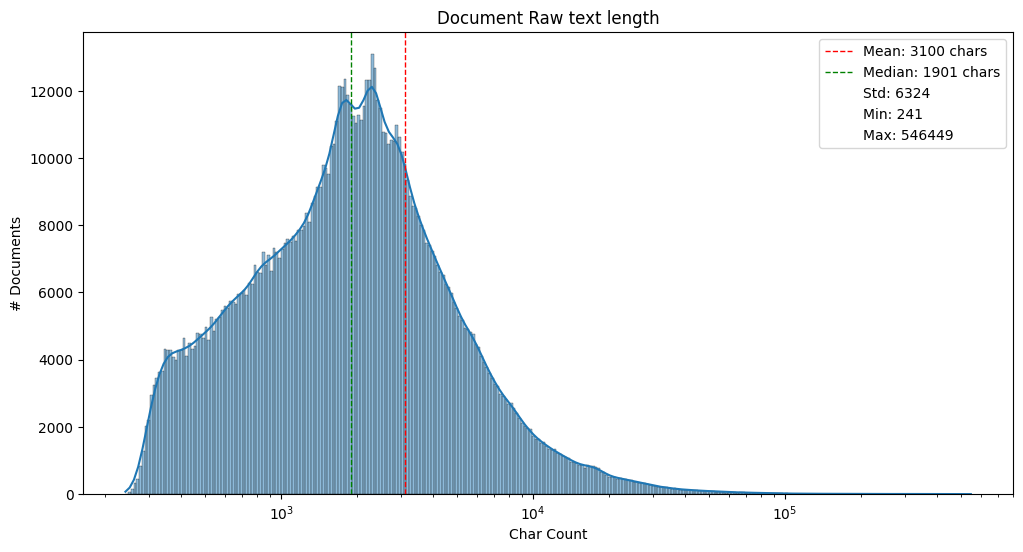

In [14]:
import matplotlib.pyplot as plt
import seaborn as sns

def plot_char_count_histogram(char_count_stats):
    char_counts = char_count_stats["char_count"]
    mean_length = char_count_stats["char_count_mean"].item()
    median_length = char_count_stats["char_count_median"].item()

    plt.figure(figsize=(12, 6))
    sns.histplot(char_counts, kde=True, log_scale=True)
    plt.axvline(mean_length, color='r', linestyle='dashed', linewidth=1, label=f'Mean: {mean_length:.0f} chars')
    plt.axvline(median_length, color='g', linestyle='dashed', linewidth=1, label=f'Median: {median_length:.0f} chars')
    plt.plot([], [], ' ', label=f'Std: {char_count_stats["char_count_std"].item():.0f}')
    plt.plot([], [], ' ', label=f'Min: {char_count_stats["char_count_min"].item()}')
    plt.plot([], [], ' ', label=f'Max: {char_count_stats["char_count_max"].item()}')
    plt.xlabel("Char Count")
    plt.ylabel("# Documents")
    plt.title("Document Raw text length")
    plt.legend()
    plt.show()

plot_char_count_histogram(fineweb2_heb_1m_stats)


#### Distribution of Documents by origin website

We want to ensure that the *FineWeb 2* 🥂 dataset contains data from various sources and is not limited to too few sources which might be biases towards certain content, topics or writing style. We also want to ensure that our sampling process - taking the fist 1M documents from the first shard of the dataset - is valid and not biased.

Having a varied and unbiased dataset is important for unsupervised tasks such as word embeddings learning and when choosing an LLM pre-training dataset, because the goal is to learn a representation of the language and its concept and so we desire a dataset that better approximates the overall population distribution. This is in stark coatrast to a fine-tuning dataset where we want the dataset to represent a certain task or domain-specific knowledge because the goal is to learn such knowledge or to perform specific tasks.

One of the ways in which we try to measure and visualize this quality of the dataset sample, is by aggregating the number of documents per Website (extracted from the original `url` feature).

We draw a wordcloud based on this measure to get a sense of some of the most common and less common websites from which documents were sourced.

We also draw a histogram of this measure to ensure that there aren't too many websites that contain a relatively large number of documents.

The histogram shows that very few websites contain more than 2500 documents per website, and the wordcloud shows that even though some websites are represented far more than others (for example the Hebrew Wikipedia, Calcalist, Haaretz, Ynet and The Marker), we recognize that these sources are varied in their topics (encyclopedia articles vs. news articles), political orientation or neutrality (Calcalist is less about right vs. left politics while Haaratez is left-leaning) as well as writing style (Wikipedia is encyclopedia where the writing style is different from news articles).

This increases our confidence that the dataset sample is varied and that our sampling process is feasible.

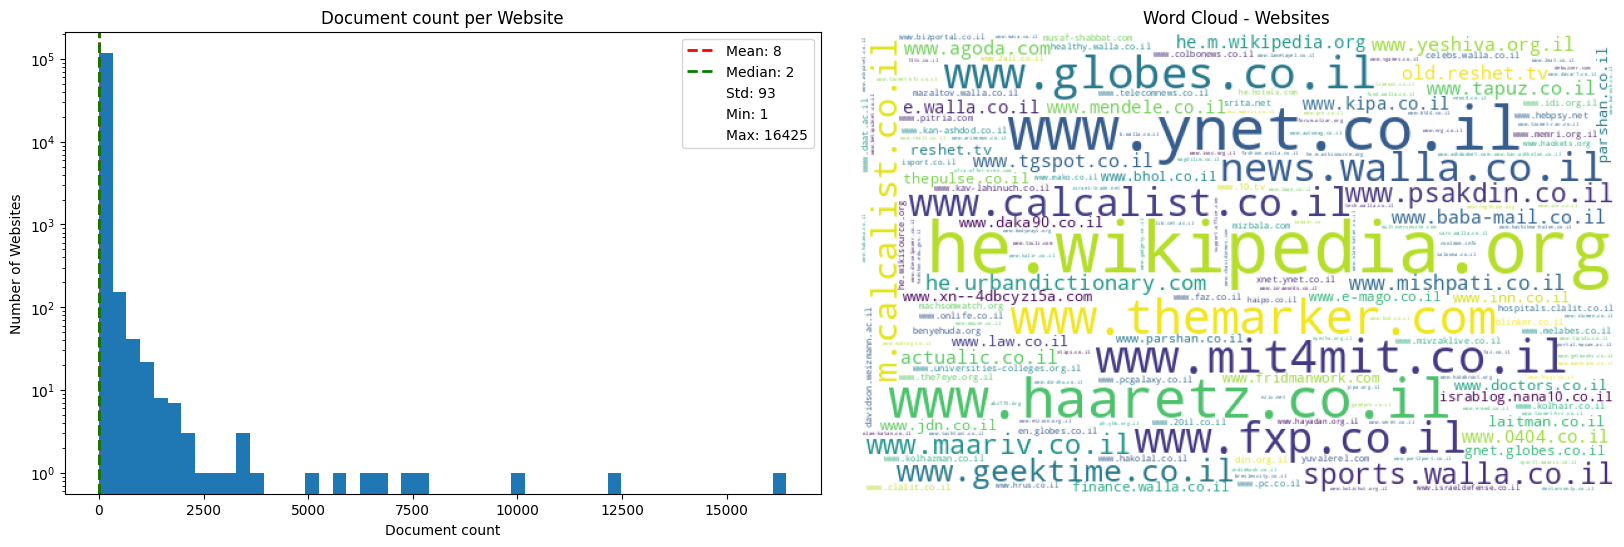

In [79]:
import matplotlib.pyplot as plt
from wordcloud import WordCloud

def draw_wordcloud_on_ax(ax, fig, wordcloud_dict, title, **kwargs):
    ax_width, ax_height = ax.get_window_extent().width, ax.get_window_extent().height
    dpi = fig.dpi
    width_inches = ax_width / dpi
    height_inches = ax_height / dpi

    wordcloud = WordCloud(width=int(width_inches * 80), height=int(height_inches * 80), background_color='white', **kwargs).generate_from_frequencies(wordcloud_dict)
    ax.imshow(wordcloud)
    ax.axis("off")
    ax.set_title(title)

def draw_website_histogram(ax, fineweb2_heb_1m_stats):
    """Draws the histogram on the given axes."""
    mean_count = fineweb2_heb_1m_stats['web_host_mean'].item()
    median_count = fineweb2_heb_1m_stats['web_host_median'].item()

    ax.hist(fineweb2_heb_1m_stats['web_host']['count'], bins=50, log=True)
    ax.axvline(mean_count, color='r', linestyle='dashed', linewidth=2, label=f'Mean: {mean_count:.0f}')
    ax.axvline(median_count, color='g', linestyle='dashed', linewidth=2, label=f'Median: {median_count:.0f}')
    ax.plot([], [], ' ', label=f'Std: {fineweb2_heb_1m_stats["web_host_std"].item():.0f}')
    ax.plot([], [], ' ', label=f'Min: {fineweb2_heb_1m_stats["web_host_min"].item()}')
    ax.plot([], [], ' ', label=f'Max: {fineweb2_heb_1m_stats["web_host_max"].item()}')
    ax.set_xlabel('Document count')
    ax.set_ylabel('Number of Websites')
    ax.set_title('Document count per Website')
    ax.legend()

def draw_website_wordcloud(ax, fineweb2_heb_1m_stats, fig):
    """Draws the word cloud on the given axes."""
    wordcloud_dict = dict(zip(fineweb2_heb_1m_stats['web_host']['web_host'], fineweb2_heb_1m_stats['web_host']['count']))
    draw_wordcloud_on_ax(ax, fig, wordcloud_dict, 'Word Cloud - Websites')

def draw_website_combined_plot(fineweb2_heb_1m_stats):
    """Initializes subplots and calls histogram and word cloud drawing functions."""
    fig, axes = plt.subplots(1, 2, figsize=(20, 6), gridspec_kw={'wspace': 0.05})
    fig.patch.set_alpha(0)

    draw_website_histogram(axes[0], fineweb2_heb_1m_stats)
    draw_website_wordcloud(axes[1], fineweb2_heb_1m_stats, fig)

    plt.show()

draw_website_combined_plot(fineweb2_heb_1m_stats)

#### Distribution of Documents by CommonCrawl metadata

Another way in which we try to measure the variance of our dataset sample is by leveraging the CommonCrawl metadata included in each row.

The *FineWeb 2* 🥂 is sourced from the *CommonCrawl* project, an endavour to crawl the entire web across **time** (document age) and **space** (document origin in the internet). In the previous section we made sure that our dataset sample is not too heavily biased across the dimension **space**, in this section we check whether it is not too heavily biased across **time**.

Each document belongs to a specific CommonCrawl-dump (the `dump` column) and is timestamped according to when the crawl was done.

This information can be used to put an lower bound on the age of the document, for example - a document that was crawled on 2013 was provably not created after 2013 but could have been before that year.

We first created a histogram to show the sampled distribution of the number of documents in a dump to make sure we did not oversampled from too few dumps, as each dump in CommonCrawl typically represents around 2 weeks worth of crawling.

We also show a histogram that shows the distribution of the number of crawled documents per day, to get a sense of how frequently we can expect a random crawl date to appear in our dataset. Our corpus represents crawled data from the year 2013 to 2024.

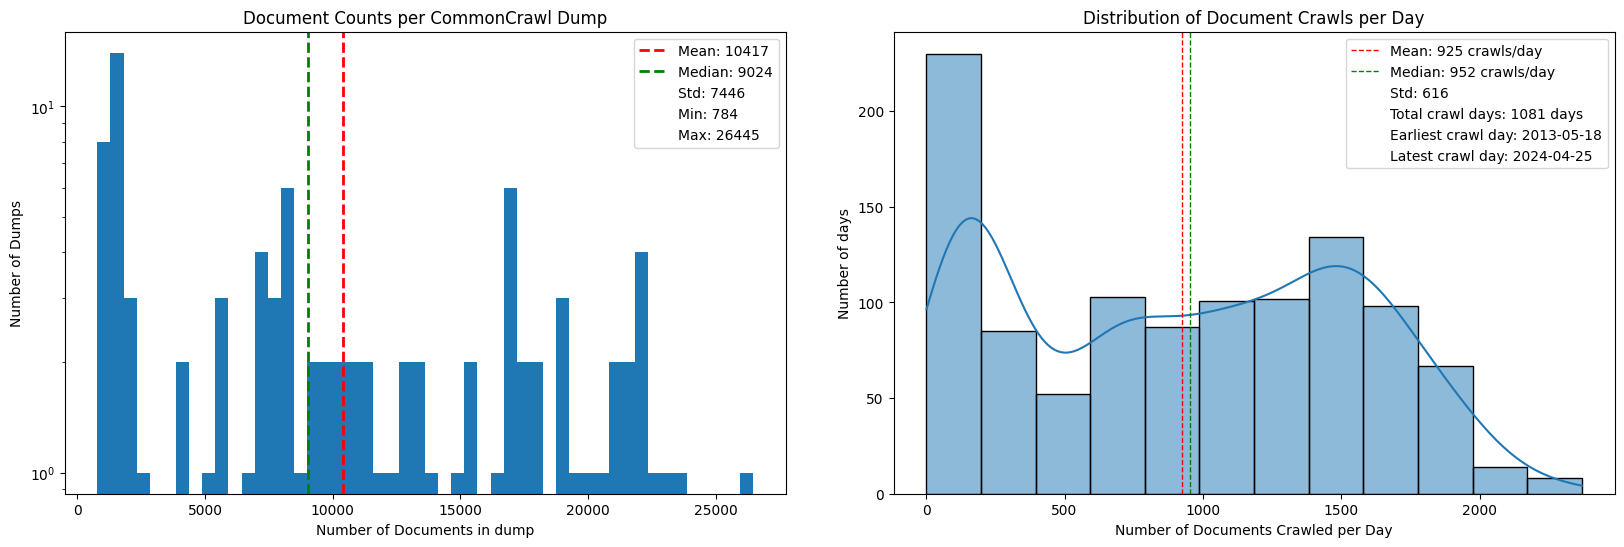

In [16]:
import matplotlib.pyplot as plt
import seaborn as sns

def draw_dump_histogram_ax(ax, fineweb2_heb_1m_stats):
    """Draws the dump histogram on the given axes."""
    mean = fineweb2_heb_1m_stats['dump_mean'].item()
    median = fineweb2_heb_1m_stats['dump_median'].item()

    ax.hist(fineweb2_heb_1m_stats['dump']['count'], bins=50, log=True)
    ax.axvline(mean, color='r', linestyle='dashed', linewidth=2, label=f'Mean: {mean:.0f}')
    ax.axvline(median, color='g', linestyle='dashed', linewidth=2, label=f'Median: {median:.0f}')
    ax.plot([], [], ' ', label=f'Std: {fineweb2_heb_1m_stats["dump_std"].item():.0f}')
    ax.plot([], [], ' ', label=f'Min: {fineweb2_heb_1m_stats["dump_min"].item()}')
    ax.plot([], [], ' ', label=f'Max: {fineweb2_heb_1m_stats["dump_max"].item()}')
    ax.set_xlabel('Number of Documents in dump')
    ax.set_ylabel('Number of Dumps')
    ax.set_title('Document Counts per CommonCrawl Dump')
    ax.legend()

def plot_crawls_per_day_ax(ax, fineweb2_heb_1m_stats):
    """Plots the distribution of crawls per day on the given axes."""
    daily_crawls = fineweb2_heb_1m_stats["date_crawled"]
    mean_crawls = fineweb2_heb_1m_stats['date_crawled_mean'].item()
    median_crawls = fineweb2_heb_1m_stats['date_crawled_median'].item()
    unique_days = daily_crawls['date_crawled'].unique().len()
    min_crawl_day = fineweb2_heb_1m_stats['date_crawled']['date_crawled'].min()
    max_crawl_day = fineweb2_heb_1m_stats['date_crawled']['date_crawled'].max()

    sns.histplot(daily_crawls["count"], kde=True, ax=ax)
    ax.axvline(mean_crawls, color='r', linestyle='dashed', linewidth=1, label=f'Mean: {mean_crawls:.0f} crawls/day')
    ax.axvline(median_crawls, color='g', linestyle='dashed', linewidth=1, label=f'Median: {median_crawls:.0f} crawls/day')
    ax.plot([], [], ' ', label=f'Std: {fineweb2_heb_1m_stats["date_crawled_std"].item():.0f}')
    ax.plot([], [], ' ', label=f'Total crawl days: {unique_days} days')
    ax.plot([], [], ' ', label=f'Earliest crawl day: {min_crawl_day}')
    ax.plot([], [], ' ', label=f'Latest crawl day: {max_crawl_day}')

    ax.set_xlabel("Number of Documents Crawled per Day")
    ax.set_ylabel("Number of days")
    ax.set_title("Distribution of Document Crawls per Day")
    ax.legend()

def draw_combined_dump_crawls(fineweb2_heb_1m_stats):
    """Initializes subplots and calls the dump histogram and crawls per day plotting functions."""
    fig, axes = plt.subplots(1, 2, figsize=(20, 6), gridspec_kw={'wspace': 0.15})
    fig.patch.set_alpha(0)
    draw_dump_histogram_ax(axes[0], fineweb2_heb_1m_stats)
    plot_crawls_per_day_ax(axes[1], fineweb2_heb_1m_stats)
    plt.show()

draw_combined_dump_crawls(fineweb2_heb_1m_stats)

#### Documents that contain Niqqud vs. not containing

The Hebrew language contains a set of special diacritical symbols called "Niqqud" which describe the proper pronounciation of words and allows the read to disambiguate the meaning of words where there is ambiguity.

For example the word *הרכבת* (HRKBT) could mean "The Train" or "Assembly", because in the former the letter *ה* (H) means the word "the" and in the latter it is simply part of the word. In order to disambiguate the word "the" in Hebrew, special Niqqud rules exist.

However in most contemporary Hebrew texts, Niqqud is not used and disambiguation and pronounciation is determined by the reader using the context in the sentence. Theoretically, proper Niqqued could help NLP systems resolve ambiguity and therefore we are interested in measuring the number of documents in our corpus which contain any Niqqud'ed words as well as the top websites containing them.

As expected, the number of documents that contain Niqqud'ed words is small compared to those without it, proving our claim about its prevalence in modern text.

/tmp/ipykernel_154634/1042895042.py:9: UserWarning: set_ticklabels() should only be used with a fixed number of ticks, i.e. after set_ticks() or using a FixedLocator.
  ax.set_xticklabels(ax.get_xticklabels(), rotation=45, ha="right")


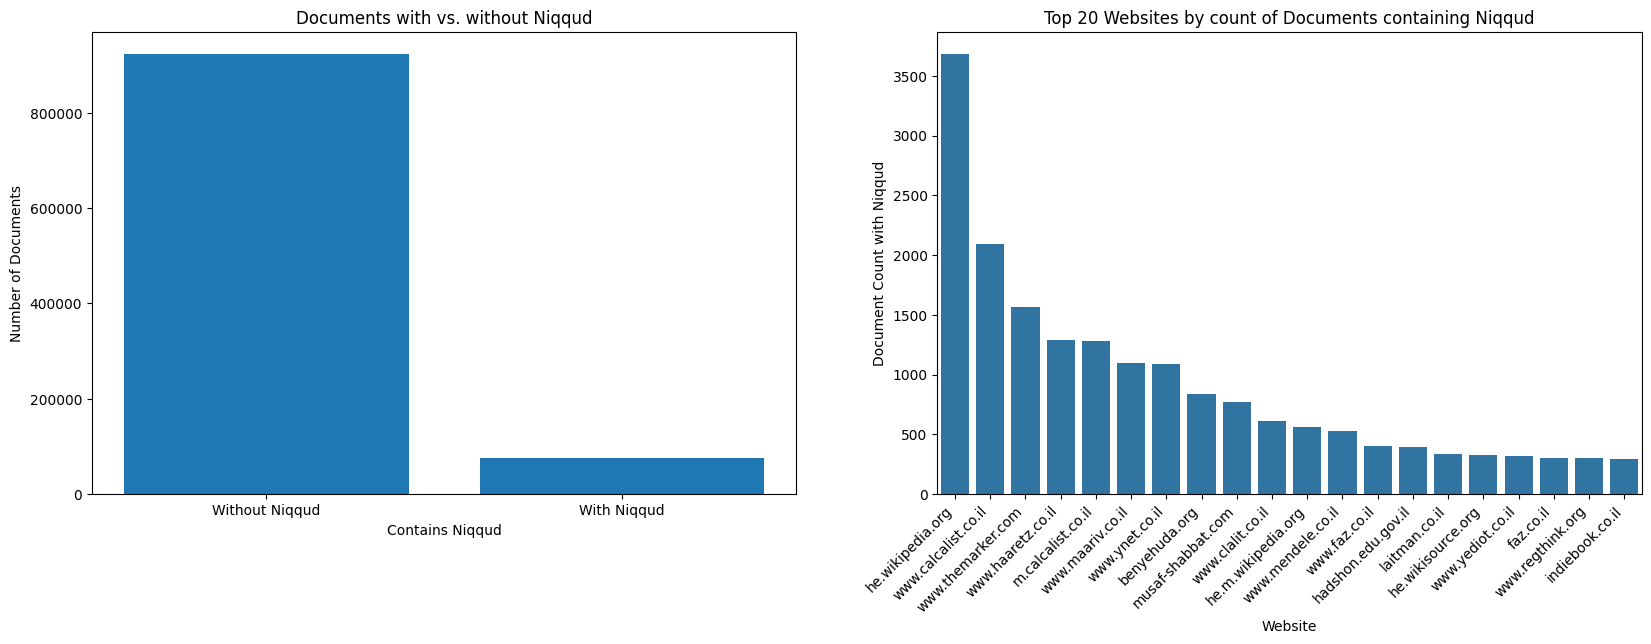

In [7]:
import matplotlib.pyplot as plt
import seaborn as sns

def plot_top_websites_with_niqqud(ax, fineweb2_heb_1m_stats):
    """Plots a barplot of the top 20 websites by document containing niqqud count."""
    top_websites = fineweb2_heb_1m_stats["contains_niqqud_by_website"].sort("count", descending=True).head(20)

    sns.barplot(x="web_host", y="count", data=top_websites, ax=ax)
    ax.set_xticklabels(ax.get_xticklabels(), rotation=45, ha="right")
    ax.set_xlabel("Website")
    ax.set_ylabel("Document Count with Niqqud")
    ax.set_title("Top 20 Websites by count of Documents containing Niqqud")

def plot_niqqud_distribution(ax, fineweb2_heb_1m_stats):
    niqqud_counts = fineweb2_heb_1m_stats["contains_niqqud"]

    ax.bar(niqqud_counts["contains_niqqud"], niqqud_counts["count"])
    ax.set_xlabel("Contains Niqqud")
    ax.set_ylabel("Number of Documents")
    ax.set_title("Documents with vs. without Niqqud")
    ax.set_xticks([True,False],["With Niqqud", "Without Niqqud"])

def plot_niqqud_stats(fineweb2_heb_1m_stats):
    fig, axes = plt.subplots(1, 2, figsize=(20, 6), gridspec_kw={'wspace': 0.2})
    fig.patch.set_alpha(0)
    plot_niqqud_distribution(axes[0], fineweb2_heb_1m_stats)
    plot_top_websites_with_niqqud(axes[1], fineweb2_heb_1m_stats)
    plt.show()

plot_niqqud_stats(fineweb2_heb_1m_stats)


#### Normalization, Tokenization and Token frequency statistics

##### Normalizing and tokenizing the corpus

In order to do anything useful with our corpus we first have to preprocess each document in it. There are several NLP preprocessing techniques that can be applied to our documents depending on the task but the most basic of them are:

**Normalization** - This is the process of transforming text into a standard form, often involving tasks like converting text to lowercase, removing punctuation, as well as stemming or lemmatizing words. This helps reduce variability and improve the consistency of the text data for further processing.

**Tokenization** - This is the process of breaking down a text into smaller units, called tokens, such as words, phrases, or symbols. This segmentation allows computers to process and analyze text more effectively.

Specifically normalization tasks can be complex and task-dependent. In Hebrew which is a Morphologically Rich Language, Stemming (chopping off word suffixes or prefixes according to some heuristics) can introduce a lot of errors and Lemmatization (reducing words into their root form by employing grammar rules) is complex, expensive and highly context dependent.

For this reason and for the purpose of our EDA, we employ a very simple normalization preprocessing step, which simply removes any diacritics characters ("Niqqud") and replaces all forms of whitespace sequences as well as non-word characters into a single whitespace character.

Our tokenization is also simple, splitting tokens on whitespace boundary.

This approach allows us to iterate faster and explore our dataset given very little preprocessing. For a more task-specific approach one can consider [HebPipe](https://github.com/amir-zeldes/HebPipe/tree/master) by Zeldes et al.

In this section we utilize this simple normalization-tokenization pipeline in order to perform a high level analysis of the frequency distribution of tokens in our corpus and try to build a Hebrew vocabulary using simple heuristics on top of this distribution. 

We utilize `polars` to load and process our dataset in chunks and thus avoid OOM issues. 

In [5]:
%%time
from tqdm.notebook import tqdm

def remove_niqqud_vectorized(text_series: pl.Series) -> pl.Series:
    """Removes niqqud from a Polars Series using vectorized operations."""
    return text_series.str.replace_all(r"[\u0591-\u05C7]", "")

def tokenize_and_count_chunk(df: pl.DataFrame) -> pl.DataFrame:
    """Tokenizes a single chunk of data and counts tokens."""
    normalized = df.select(
        pl.col("text")
        .pipe(remove_niqqud_vectorized)
        .str.replace_all(r"(\s+)|([^\w\s])", " ")
        .str.strip_chars()
        .str.split(" ")
        .alias("token")
    )
    token_counts = (
        normalized.explode("token")
        .filter(pl.col("token") != "")  # Filter empty strings
        .group_by("token")
        .len(name="count")
    )
    return token_counts

def get_token_freq_chunked(file_path: str, n_rows: int| None = None, chunk_size: int = 100_000) -> pl.DataFrame:
    """
    Calculates token frequencies from a Parquet file in chunks.

    Args:
        file_path: Path to the Parquet file.
        n_rows: Total number of rows to process.
        chunk_size: Number of rows to process per chunk.

    Returns:
        A Polars DataFrame with 'token' and 'count' columns, sorted by count.
    """
    if n_rows is None:
        # Efficiently get the row count without loading the data
        n_rows = pl.scan_parquet(file_path).select(pl.len()).collect().item()
    total_counts = None
    total_rows_processed = 0
    i = 0  # Chunk counter

    with tqdm(total=n_rows, desc="Processing Chunks", unit="rows") as pbar:
        while total_rows_processed < n_rows:
            rows_to_read = min(chunk_size, n_rows - total_rows_processed)
            chunk = pl.scan_parquet(file_path, n_rows=rows_to_read, row_index_name="row_index", row_index_offset=i * chunk_size)
            chunk_df = chunk.collect()

            num_rows_read = chunk_df.shape[0]
            if num_rows_read == 0:
                break

            chunk_counts = tokenize_and_count_chunk(chunk_df)

            if total_counts is None:
                total_counts = chunk_counts
            else:
                total_counts = (
                    pl.concat([total_counts, chunk_counts])
                    .group_by("token")
                    .agg(pl.col("count").sum())
                )

            total_rows_processed += num_rows_read
            i += 1
            pbar.update(num_rows_read)  # Update progress bar

    if total_counts is not None:
        total_counts = total_counts.sort("count", descending=True)
    return total_counts


    # Sort by count after all chunks are processed.
    if total_counts is not None:
        total_counts = total_counts.sort("count", descending=True)
    return total_counts

simple_token_freq = get_token_freq_chunked(FINE_WEB_2_HEB_SAMPLE_0_PATH)

print(f"Total tokens extracted: {simple_token_freq.select(pl.col('count').sum()).item()}")
print(simple_token_freq.head())
print(simple_token_freq.shape)

Processing Chunks:   0%|          | 0/2669000 [00:00<?, ?rows/s]

Total tokens extracted: 1461856000
shape: (5, 2)
┌───────┬──────────┐
│ token ┆ count    │
│ ---   ┆ ---      │
│ str   ┆ u32      │
╞═══════╪══════════╡
│ של    ┆ 27020995 │
│ את    ┆ 25761964 │
│ על    ┆ 18146420 │
│ לא    ┆ 11941494 │
│ עם    ┆ 7936894  │
└───────┴──────────┘
(960839, 2)
CPU times: user 11min 11s, sys: 1min 1s, total: 12min 12s
Wall time: 1min 24s


#### Token frequency distribution

Our simple preprocessing pipeline yields almost 960K unique tokens and a total of 1.461 Trillion tokens.
Many of these tokens are either invalid words, words in other languages or just extremely uncommon words.

If we wanted to construct a vocabulary out of our tokenized corpus, just using the 960K tokens is probably too much and contains a lot of noise.
For example Gueta et al used 128K vocabulary size for training AlephBERTGimmel and Tsarfaty et al used 52K for AlephBERT and Chriqui et al used 30.5K for HeBERT. And while constructing a vocabulary based on data we already tokenized in a certain way and under certain assumptions is different from learning a vocabulary by using sub-word tokenization algorithms like WordPiece (for BERT models) or like BPE (GPT and others), it does give us a *sense* of what kind of vocabulary size to aim for.

We observe that the median token frequency in the tokenized corpus is **53** and the mean token frequency is **1521**, We also observe that in total, below median tokens account for around **1%** of the total amount of tokens in the dataset and that below mean tokens account for less than **9%**. Using these values, we try two simple heuristical methods for reducing the unique token count in our vocabulary:

1. Remove any tokens whose frequency is less than or equal to the median.
2. Remove any tokens whose frequency is less than or equal to the mean.

The advantage of using these methods is simplicity and speed as no special algorithm is used and no further pre or post processing is required beyond what we already did. Indeed, while filtering based on the median value still yields a very large vocabulary of 461K tokens, **filtering based on the mean** yields a vocaulary size of 67K tokens, close to the sizes used in the Hebrew BERT models discussed eariler, while retaining over 91% of the total tokens in the corpus.

Another interesting observation is the Mean to Median ratio that decreases monotonically as we remove the less frequent tokens, which could be interpreted as reducing noise or skewness in our dataset. 

This result presents another aspect in validating the choice of Hebrew vocabulary sizes in the tens of thousands, by stochastically minimizing the tradeoff between a concise vocabulary and minimal data loss, according to very simple statistical-guided heuristics.

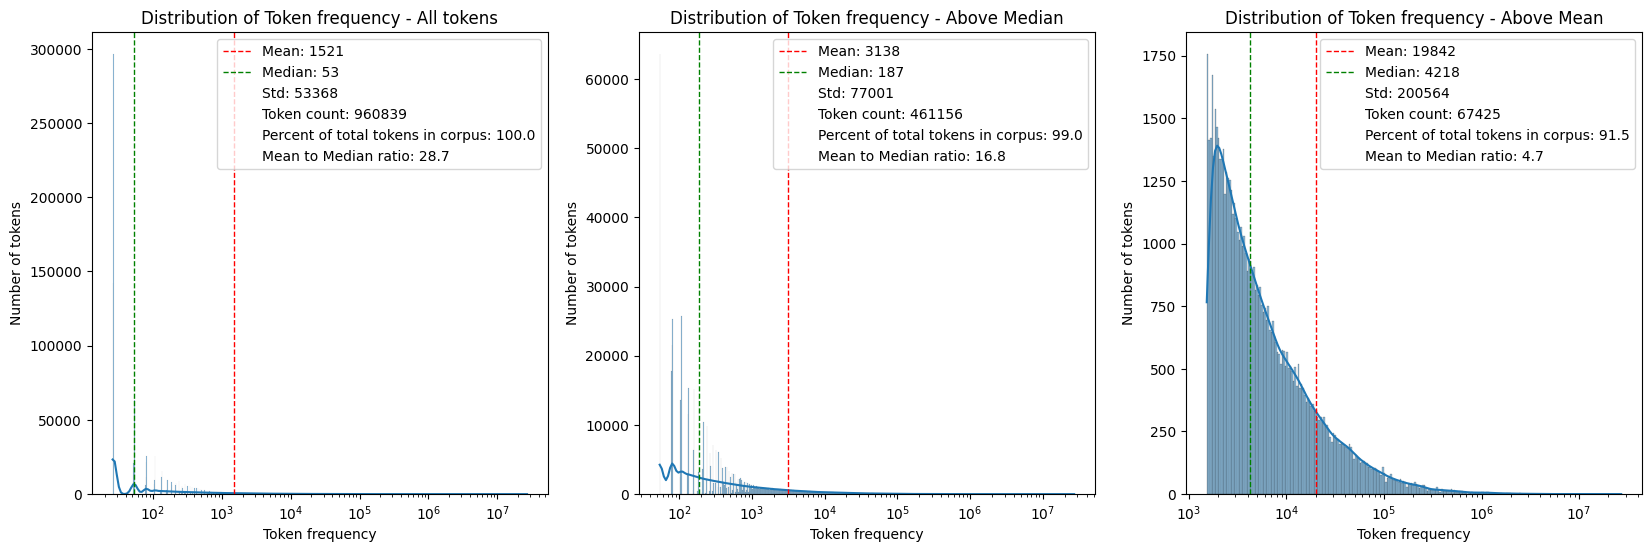

In [8]:
def plot_token_dist(simple_token_freq, ax, percent, title="Distribution of Token frequency - All tokens"):
    """Plots the distribution of tokens in the corpus."""
    mean = simple_token_freq['count'].mean()
    median = simple_token_freq['count'].median()
    min = simple_token_freq['count'].min()
    max = simple_token_freq['count'].max()
    std = simple_token_freq['count'].std()
    token_count = simple_token_freq['count'].shape[0]

    sns.histplot(simple_token_freq["count"], kde=True, ax=ax, bins="sqrt",log_scale=True)
    ax.axvline(mean, color='r', linestyle='dashed', linewidth=1, label=f'Mean: {mean:.0f}')
    ax.axvline(median, color='g', linestyle='dashed', linewidth=1, label=f'Median: {median:.0f}')
    ax.plot([], [], ' ', label=f'Std: {std:.0f}')
    ax.plot([], [], ' ', label=f'Token count: {token_count:.0f}')
    ax.plot([], [], ' ', label=f'Percent of total tokens in corpus: {percent:.1f}')
    ax.plot([], [], ' ', label=f'Mean to Median ratio: {mean/median:.1f}')

    ax.set_xlabel("Token frequency")
    ax.set_ylabel("Number of tokens")
    ax.set_title(title)
    ax.legend()

def get_tokens_above_median(simple_token_freq):
    return simple_token_freq.filter(pl.col('count') > simple_token_freq['count'].median())

def get_tokens_above_mean(simple_token_freq):
    return simple_token_freq.filter(pl.col('count') > simple_token_freq['count'].mean())

def plot_vocab_options(simple_token_freq):
    """Creates three plots with different filtering options."""
    fig, axes = plt.subplots(1, 3, figsize=(20, 6))
    fig.patch.set_alpha(0)

    # Plot 1: Unfiltered vocabulary
    plot_token_dist(simple_token_freq, axes[0], 100, title="Distribution of Token frequency - All tokens")

    # Plot 2: Filtered by median
    median_filtered_df = get_tokens_above_median(simple_token_freq)
    above_median_percent = 100 * median_filtered_df['count'].sum() / simple_token_freq['count'].sum()
    plot_token_dist(median_filtered_df, axes[1], above_median_percent, title="Distribution of Token frequency - Above Median",)

    # Plot 3: Filtered by mean
    mean_filtered_df = get_tokens_above_mean(simple_token_freq)
    above_mean_percent = 100 * mean_filtered_df['count'].sum() / simple_token_freq['count'].sum()
    plot_token_dist(mean_filtered_df, axes[2], above_mean_percent, title="Distribution of Token frequency - Above Mean")

    plt.show()
    
plot_vocab_options(simple_token_freq)

## Stop-word Mining and comparison to other datasets

In classic Natural Language Processing (NLP), "stop words" refer to a set of commonly used words in a language that are often filtered out or removed from text during processing. There is some ambiguity around the definition of Stop-words, some practitioners (for example [Kavita Genesan](https://kavita-ganesan.com/what-are-stop-words/) ) define them as words common to **many** languages rather than a **single** language. This is the defintion also used by Tsarfaty et al, the team behind [NNLP-IL](https://nnlp-il.mafat.ai/).

The reasons for stop word removal in various NLP tasks can be summarized as:

**Noise reduction**
* By removing stop words, NLP algorithms can focus on the more important and semantically meaningful words, reducing "noise" in the data.

**Efficiency improvements**
* Removing these frequent words reduces the size of the text data, which can significantly improve the speed and efficiency of NLP tasks, especially when dealing with large datasets such as *FineWeb 2* 🥂.

**Accuracy improvements**
* In tasks like text classification, information retrieval, and topic modeling, removing stop words can help algorithms identify the key themes and patterns more accurately, eliminating frequently occuring words that can throw off the algorithm's results.

We will utilize topic modelling techniques as well as word embeddings in order to visually cluster documents in our dataset, and since our dataset is quite large, getting a proper list of stop words and filtering them from our corpus will arguably be important.

In order to come up with a decent list of stop words, we will utilize both our tokenized sample from the *FineWeb 2* 🥂 dataset, as well as two [curated lists prepared by NNLP-IL](https://github.com/NNLP-IL/Stop-Words-Hebrew/tree/main).

We will compare the top frequent words from our list with those from NNLP, and hypothesize about some of the differences, eventually drawing some conclusion.



### Most frequent tokens

After completing our Normalization and Tokenization steps we plot the 20 most frequent tokens appearing in our dataset sample.

This plot can help us identify some likely candidates for stop words. We can see that some words - ***של, את, על, לא*** are encountered several times more frequently in our corpus than other words, making them highly likely to be included in our list.

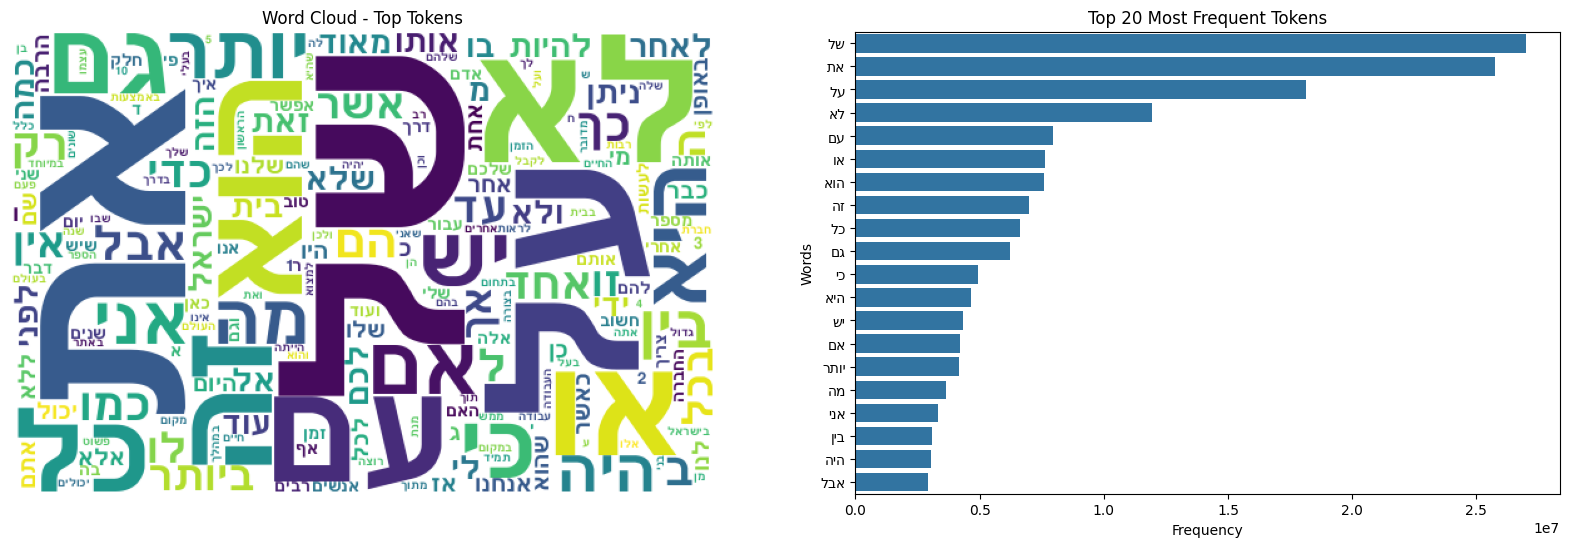

In [80]:
from wordcloud import WordCloud
from bidi import get_display
import seaborn as sns

def plot_frequent_tokens_ax(ax, df: pl.DataFrame, top_n: int = 20, title_prefix: str = ""):
    """
    Plots the top N most frequent tokens using seaborn barplot on the given axes.

    Args:
        ax: The matplotlib axes to draw the plot on.
        df: A Polars DataFrame with columns 'text' and 'count'.
        top_n: The number of top frequent words to plot.
    """
    top_words = df.sort("count", descending=True).head(top_n)
    top_words = top_words.with_columns(
        pl.col("token").map_elements(
            get_display, return_dtype=pl.String
        ).alias("token")
    )

    sns.barplot(x="count", y="token", data=top_words, ax=ax)
    ax.set_title(f"{title_prefix}Top {top_n} Most Frequent Tokens")
    ax.set_xlabel("Frequency")
    ax.set_ylabel("Words")

def draw_token_wordcloud(ax, word_frequencies, fig):
    """Draws the word cloud on the given axes."""
    as_dict = word_frequencies.to_dict(as_series=False)
    wordcloud_dict = dict(zip(as_dict['token'], as_dict['count']))
    draw_wordcloud_on_ax(ax, fig, wordcloud_dict, 'Word Cloud - Top Tokens', font_path="./FreeSansBold.ttf")

def draw_combined_token_plot(word_frequencies):
    """Combines the word cloud and table into a single plot."""
    fig, axes = plt.subplots(1, 2, figsize=(20, 6), gridspec_kw={'wspace': 0.2})
    fig.patch.set_alpha(0)
    draw_token_wordcloud(axes[0], word_frequencies, fig)
    plot_frequent_tokens_ax(axes[1], word_frequencies)
    plt.show()

draw_combined_token_plot(simple_token_freq)

### NNLP-IL Hebrew Stop-Words dataset

#### Importing Stop-word lists from NNLP-IL Hebrew Stop-Words Repository

NNLP-IL has curated two lists of Hebrew stop-word, a short one and and extended one.

* The "short" list is made of words from a Parts-of-Speech tagged dataset prepared by The Israeli Association of Human Language Technologies (IAHLT). The set of words inside that dataset were intersected by the authors with the set of 1000 most frequent words in the Hebrew Wikipedia (at time of creation) in order to produce the "short" list.

* The "extended" list is a union of the IAHLT list along with the 50 most frequent words in the Hebrew Wikipedia and a custom list of Hebrew Preprositions (מילות יחס) added by the authors.

The authors also produced a list of the 3000 most frequent words in the Hebrew Wikipedia at the time (visualized below) which we compare to our *FineWeb 2* 🥂 sample.

We will replicate this process of creating the stop word lists - *FineWeb 2* 🥂 sample instead of the Hebrew Wikipedia - and compare the results.

In [6]:
# Dataset cloned from https://github.com/NNLP-IL/Stop-Words-Hebrew/tree/main
def get_nnlp_il_short_stopword_list() -> pl.DataFrame:
  return pl.read_csv("./Stop-Words-Hebrew/stopswords_list_short.txt", separator=" ")

def get_nnlp_il_extended_stopword_list() -> pl.DataFrame:
  return pl.read_csv("./Stop-Words-Hebrew/stopswords_list_extend.txt", separator=" ")

def get_nnlp_il_top_3k_freq_wiki_list() -> pl.DataFrame:
  df = pl.read_csv("./Stop-Words-Hebrew/top_3000_most_freq_wiki.csv")
  return df.select([col for idx, col in enumerate(df.columns) if idx != 0]).rename({'word': 'token', 'frequency': 'count'})

#### Hebrew Wikipedia - 3000 Top Frequent words

Plotting the word cloud of the Hebrew Wikipedia, we can visibly observe words such as:

"כ" ("approximately")

"בינואר" ("In January")

"באוגוסט" ("In August")

"במרץ"  ("In March")

"בשנת"  ("In the year of")

This shows us that relying solely on Wikipedia corpus can introduce a lot  of bias towards words and phrases that are prevalent in the kind of content found in an encyclopedia and its associated writing style. Intuitively we know that this writing style is different from everyday speech and from blog and news media around the web.

Our *FineWeb 2* 🥂 sample dataset contains documents from a variety of websites spanning different writing styles and topics and while it may contain more "noise" and invalid words, it can also help in reducing this bias for many NLP applications which would use it as a pre-training dataset for language modelling.

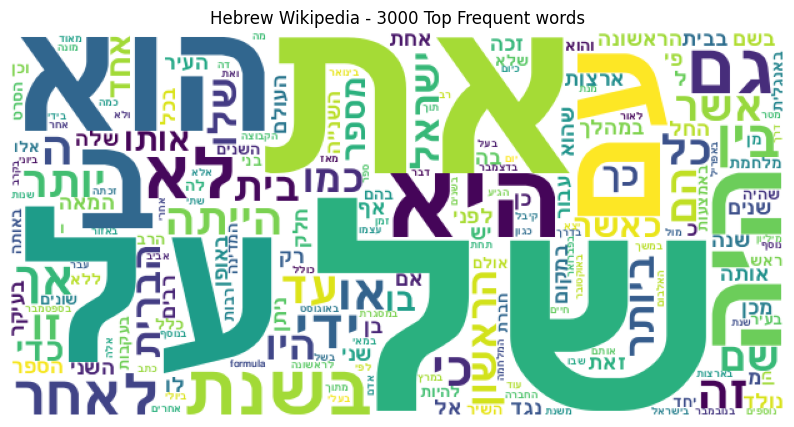

In [87]:
import matplotlib.pyplot as plt
from wordcloud import WordCloud
def create_wordcloud_3k_most_freq_wiki(df: pl.DataFrame):
    fig = plt.figure(figsize=(10, 5))
    fig.add_subplot(111)
    wordcloud_dict = dict(zip(df['token'], df['count']))
    draw_wordcloud_on_ax(fig.axes[0], fig, wordcloud_dict, 'Hebrew Wikipedia - 3000 Top Frequent words', font_path="./FreeSansBold.ttf")
    plt.show()

top_3k_words = get_nnlp_il_top_3k_freq_wiki_list()
create_wordcloud_3k_most_freq_wiki(top_3k_words)

#### Comparing Top 20 Most Frequent tokens to NNLP-IL Wikipedia Dataset

We plot the 20 most frequent tokens inside Top 3000 Wikipedia words and our *FineWeb 2* 🥂 sample dataset and compare their overlapping and non-overlapping tokens.

Interestingly, the words "של" (the Possesive relation), "את" (term used to indicate a direct object) and "על" ("On" - Preprosition) are the most frequent in both datasets and have the same rank in both. This and the fact that in total 13 out 20 of the top words in either datasets overlap between the datasets means there is some consensus between them and these words could qualify as stop words.

We notice also that in terms of frequency, our dataset sample contains these top words in the $10^7$ scale (total count), and the Wikipedia dataset is on the $10^6$ scale reduces the likelyhood of the Wikipedia-sourced documents in our *FineWeb 2* 🥂 sample to have caused a significant bias towards this agreement between the two datasets.

On the non-overlapping part, we notice words such as "ב" ("in" - Preprosition), "בשנת" ("in the year of), "לאחר" ("after"), "ה" ("the") and "עד" ("until"). All of which are prevalent (by qualitative observations) inside Wikipedia articles in Hebrew.

Contrast to that, in the *FineWeb 2* 🥂 sample we see top words such as "אני" ("I"), "מה" ("What"), "אבל" ("but"), "אם" ("if"). These words are prevalent in questions and first-person sentences which are less frequent in encyclopedic writing style and content.

We also notice that the fact words such as "ב" ("in" - Preprosition) and "ה" ("the") are less common in our dataset sample, could be in some part attributed to the lack of Parts-Of-Speech and Word Disambiguation during our Normalization and Tokenization process.

In Hebrew, the words "the" and "in" can be prefixed into the noun, requiring proper disambiguation. On Wikipedia documents, such prefixing is usually normalized by the authors by inserting a hyphen ("-") whenever the noun is a Date, a Number or a term in a foreign language. This can help a simple tokenizer such as ours detect these words as separate tokens but is not guaranteed in other internet-sourced documents such as blog posts, comments and news articles.

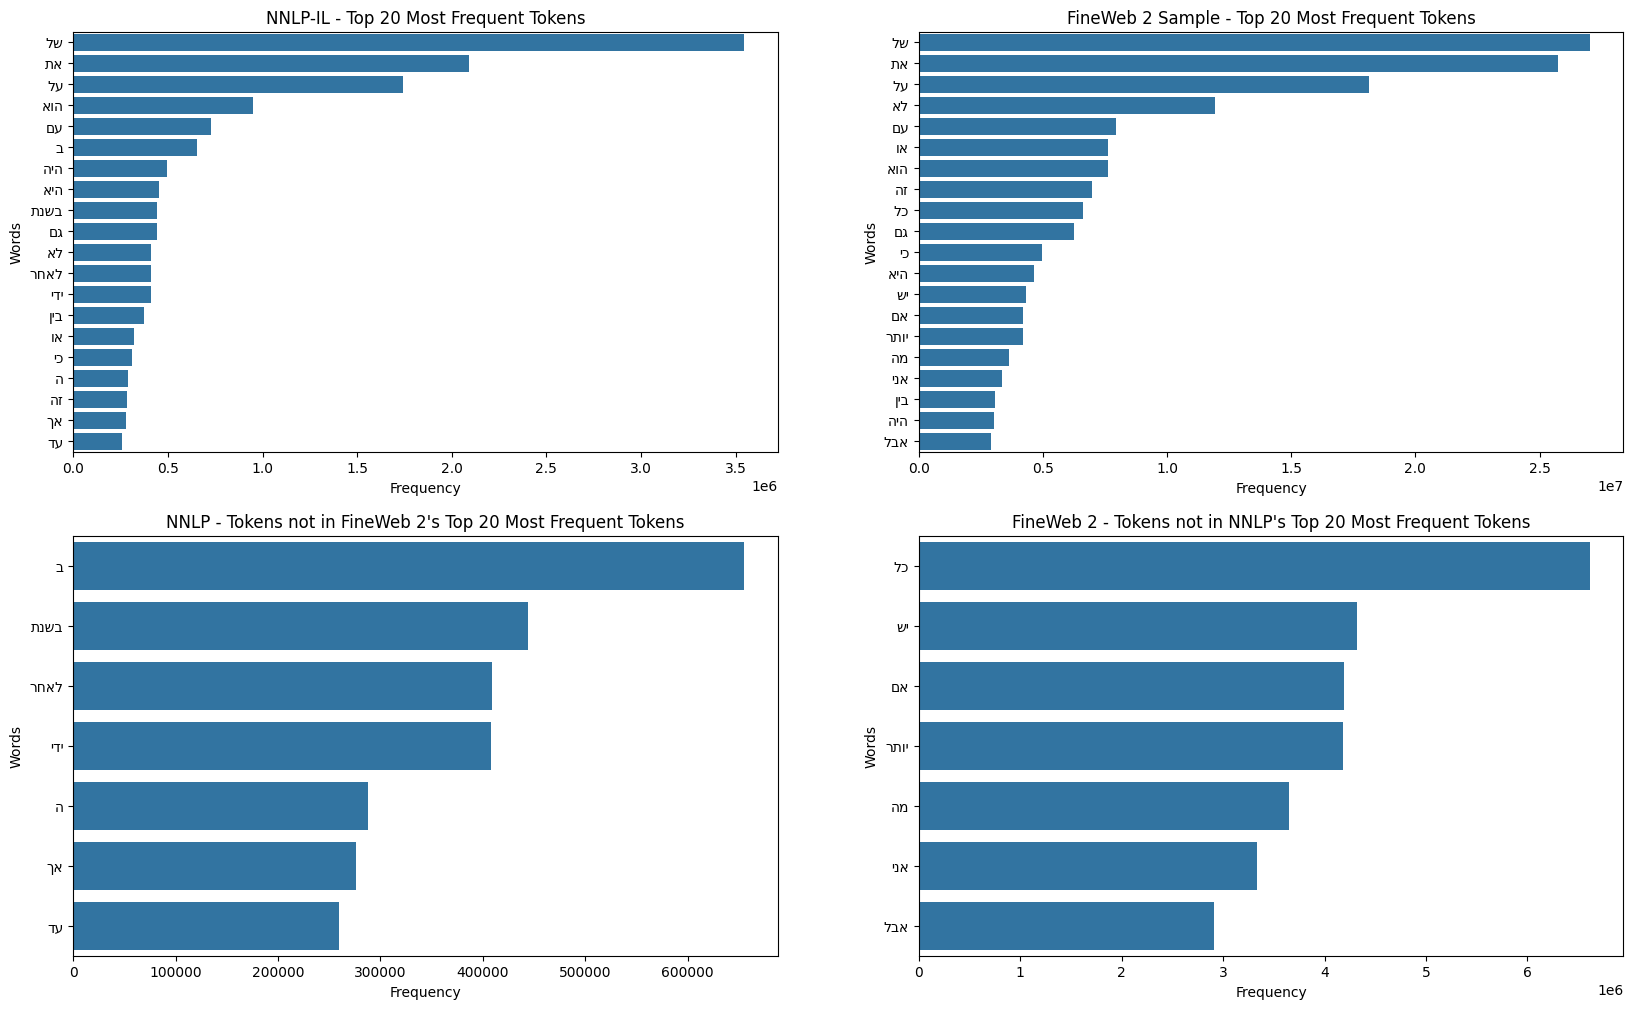

In [64]:
def draw_compare_nnlp_il_3k_to_fineweb(nnlp_df, finweb_df: pl.DataFrame, top_n: int = 20):
    fig, axes = plt.subplots(2, 2, figsize=(20, 12), gridspec_kw={'wspace': 0.2, 'hspace': 0.2})
    fig.patch.set_alpha(0)
    plot_frequent_tokens_ax(axes[0][0], nnlp_df, top_n, title_prefix="NNLP-IL - ")
    plot_frequent_tokens_ax(axes[0][1], finweb_df, top_n, title_prefix="FineWeb 2 Sample - ")

    top_words_fineweb = finweb_df.sort("count", descending=True).head(top_n)
    top_words_nnlp = nnlp_df.sort("count", descending=True).head(top_n)
    finweb_mins_nnlp = top_words_fineweb.filter(~top_words_fineweb["token"].is_in(top_words_nnlp["token"]))
    nnlp_mins_finweb = top_words_nnlp.filter(~top_words_nnlp["token"].is_in(top_words_fineweb["token"]))

    plot_frequent_tokens_ax(axes[1][0], nnlp_mins_finweb, top_n, title_prefix="NNLP - Tokens not in FineWeb 2's ")
    plot_frequent_tokens_ax(axes[1][1], finweb_mins_nnlp, top_n, title_prefix="FineWeb 2 - Tokens not in NNLP's ")

draw_compare_nnlp_il_3k_to_fineweb(get_nnlp_il_top_3k_freq_wiki_list(), simple_token_freq)

##### Illustrating the prevalence of some Wikipedia-specific common words

In the screenshots below we selected some random articles in the Hebrew Wikipedia, showcasing (qualitatively) how words such as "ב" ("in" - Preprosition) and "ה" ("the") are both frequent in the text and are normalized in such as way as discussed above.

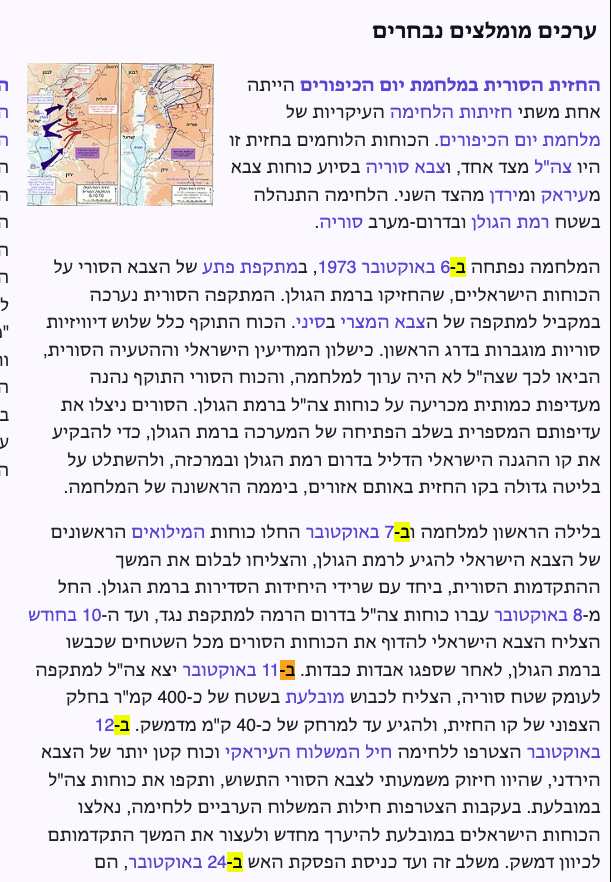

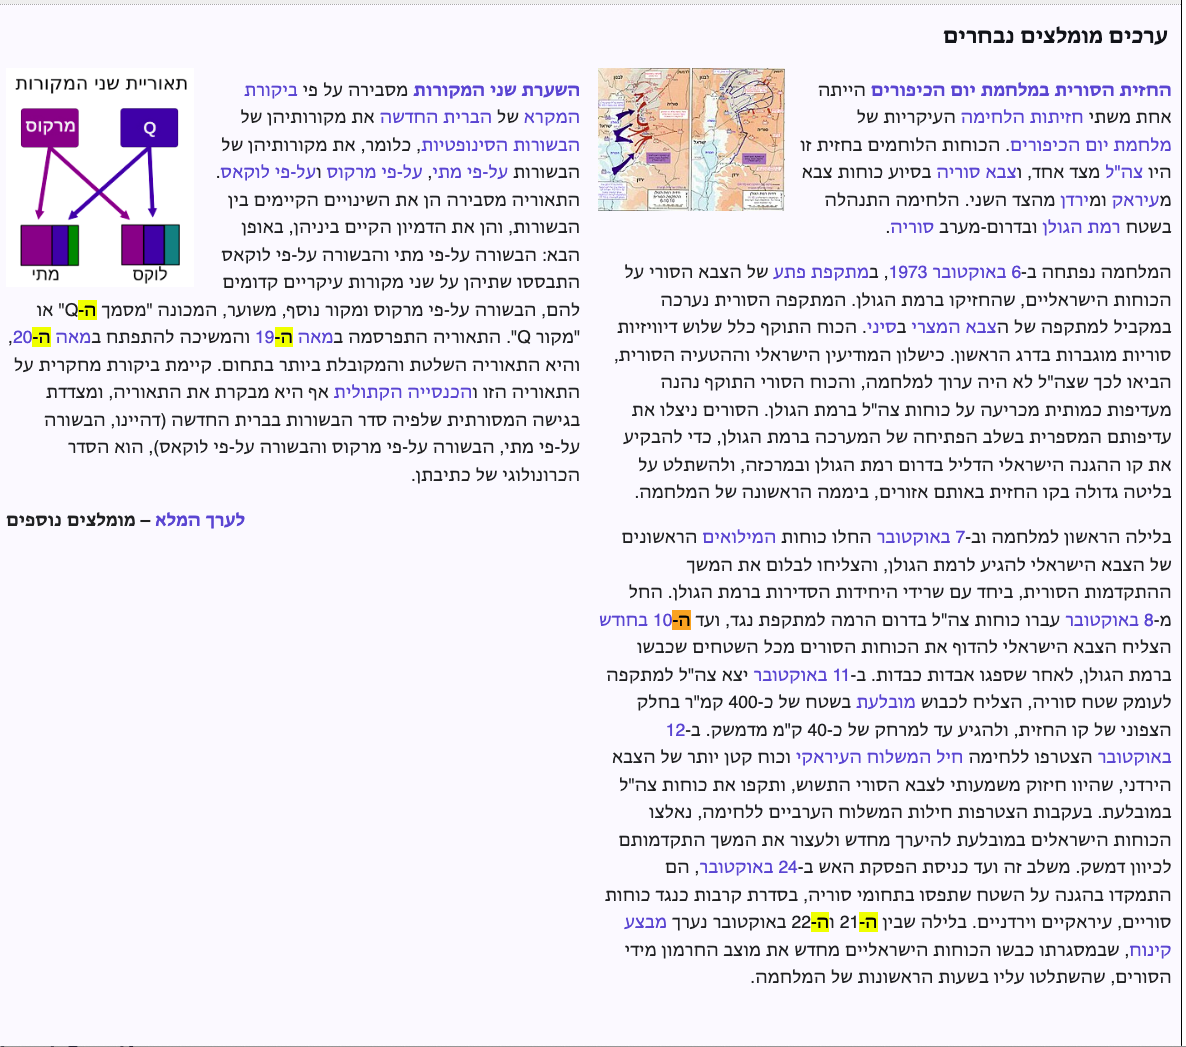

### Mining for stop-words

We implement the same process used in the [NNLP Stop Word Notebook](https://github.com/NNLP-IL/Stop-Words-Hebrew/blob/main/prepare_stop_word.ipynb) for creating the stop word lists.

Instead of using only Wikipedia as the corpus for token frequencies we use our preprocessed *FineWeb 2* 🥂 sample.

We adapted the notebook's code to accept our dataset of token frequencies as a function paramter, and we encapsulated the whole process inside a single function `nnlp_stopword_mining_pipeline` and added relevant documentation where the original code was lacking it.

In [7]:
# Adapted from https://github.com/NNLP-IL/Stop-Words-Hebrew/blob/main/prepare_stop_word.ipynb
import numpy as np
import pandas as pd
import requests as req
import pyconll

def remove_niqqud_from_string(my_string):
  # Taken from https://github.com/NNLP-IL/Stop-Words-Hebrew/blob/main/prepare_stop_word.ipynb
  return "".join(["" if 1456 <= ord(c) <= 1479 else c for c in my_string])

def get_data(url: str, name: str):
  """Download text file"""
  res = req.get(url)
  file = open(name + ".txt", "w")
  file.write(res.text)
  file.close()

def load_iahlt_data():
  """Load the IAHLT Universal Dependencies Hebrew dataset."""
  ud_dev = "https://raw.githubusercontent.com/UniversalDependencies/UD_Hebrew-IAHLTwiki/master/he_iahltwiki-ud-dev.conllu"
  ud_test = "https://github.com/UniversalDependencies/UD_Hebrew-IAHLTwiki/raw/master/he_iahltwiki-ud-test.conllu"
  ud_train = "https://github.com/UniversalDependencies/UD_Hebrew-IAHLTwiki/blob/master/he_iahltwiki-ud-train.conllu?raw=true"

  get_data(ud_dev, "ud_dev")
  get_data(ud_test, "ud_test")
  get_data(ud_train, "ud_train")
  dev = pyconll.load_from_file("./ud_dev.txt")
  train = pyconll.load_from_file("./ud_test.txt")
  test = pyconll.load_from_file("./ud_train.txt")

  return dev, train, test


def extract_stopwords(dat: pyconll):
  """Extracts stopwords from the input file given in Universal Dependencies schema format.
    It extract the stopwords according to the annotated word class in the sentence:
    DET: Determiners (e.g., "the," "a," "an")
    ADP: Adpositions (prepositions and postpositions) (e.g., "in," "on," "at")
    PRON: Pronouns (e.g., "he," "she," "it")
    CCONJ: Coordinating conjunctions (e.g., "and," "or," "but")
    SCONJ: Subordinating conjunctions (e.g., "that," "if," "because")
    SYM: Symbols.
  """
  POS_tag = ["DET", "ADP", "PRON", "CCONJ", "SCONJ", "SYM"]
  lst_words = [
      token.form for sentence in dat for token in sentence if token.upos in POS_tag
  ]
  return lst_words

def get_prepositions():
  """Returns a list of common Hebrew prepositions in every inflection. """
  al = ["אלי", "אליך", "אליך", "אליו", "אליה", "אלינו", "אליכם", "אליכן", "אליהם", "אליהן"]
  hal = ["עלי", "עליך", "עליך", "עליו", "עליה", "עלינו", "עליכם", "עליכן", "עליהם", "עליהן"]
  him = ["עמי", "עמך", "עמו", "עמה", "עמנו", "עמכם", "עמכן", "עמם",  "עמן", "עמהם", "עמהן"]
  ath_with = ["אתן", "אתם", "אתכן", "אתכם", "אתנו", "אתה", "אתו", "אתך", "אתי"]
  ath = ["אותי", "אותך", "אותו", "אותה", "אותנו", "אתכם", "אתכן", "אותם", "אותן"]
  shel = ["שלי", "שלך", "שלו", "שלה", "שלנו", "שלכם", "שלכן", "שלהם", "שלהן"]
  men = ["ממני", "ממך", "ממנו", "ממנה", "מכם", "מכן", "מהם", "מהן"]
  azhel = ["אצלי", "אצלך", "אצלו", "אצלה", "אצלנו", "אצלכם", "אצלכן", "אצלם", "אצלן"]
  bshvil = ["בשבילי", "בשבילך", "בשבילו", "בשבילה", "בשבילנו", "בשבילכם", "בשבילכן", "בשבילם", "בשבילן"]
  bin = ["ביני", "בינך", "בינו", "בינה", "בינינו", "ביניכם", "ביניכן", "ביניהם", "ביניהן", "בינם", "בינן"]
  lafi = ["לפי", "לפיך", "לפיו", "לפיה", "לפינו", "לפיכם", "לפיכן", "לפיהם", "לפיהן"]
  lafni = ["לפני", "לפניך", "לפניו", "לפניה", "לפנינו", "לפניכם", "לפניכן", "לפניהם", "לפניהן"]
  chmo = ["כמוני", "כמוך", "כמוהו", "כמוה", "כמונו", "כמוכם", "כמוכן", "כמוהם", "כמוהן"]
  lakrt = ["לקראתי", "לקראתך", "לקראתו", "לקראתה", "לקראתנו", "לקראתכם", "לקראתכן", "לקראתם", "לקראתן"]
  pepositions = {"אל": al, "על": hal, "עם": him, "(=עם) את": him, "את (תוויות מושא ישיר": ath, "של": shel, "מן": men, "אצל": azhel,
                "בשביל": bshvil, "בין": bin, "לפי": lafi, "לפני": lafni, "כמו": chmo, "לקראת": lakrt
  }
  return [item for sublist in list(pepositions.values()) for item in sublist]

def create_base_stopword_list():
  """Creates a base list of Hebrew Stop words by mining the annotated IAHLT Universal Dependencies Hebrew dataset."""
  dev, train, test = load_iahlt_data()
  # Extracts the stopwords form the UD Schema
  stopwords_raw = set(
      extract_stopwords(dev) + extract_stopwords(train) + extract_stopwords(test)
  )
  # Remove Niqqud from words
  stopwords_raw = set(map(remove_niqqud_from_string,stopwords_raw))
  # Un-annotated words in the IAHLT annotated dataset that the researchers identified as qualifying as stop words
  missing_words = { "אגב", "הואיל", "הלא", "הרי", "כיאלו", "כיון", "יען", "על" "מנת", "ודאי", "גם", "אפילו", "יש", "רק", }
  # Add the missing words
  stopwords_base = stopwords_raw | missing_words
  # Some non-stopword tokens the researchers identified that are returned from the extract_stopwords function applied to the IAHLT dataset
  invalid_tokens = { "%", "&", "(", "+", "-", "/", ":", "=", "–", "°", "בינ", "שורת", "אודות", 'אודותי', 'דם', "לאזור", "במקביל", "כשב-1948",
      "ד", "בתוכ", "הו", "י", "ך", "ם", "ן", "נ'", "נאומ", 'למחרת', 'אות', 'אית', 'ספר', 'ערב'  }
  # Delete the invalid tokens
  stopwords_base = stopwords_base - invalid_tokens

  return stopwords_base

def nnlp_stopword_mining_pipeline(finweb_df: pl.DataFrame):
  """Create a short and extended list of stop words using the annotated IAHLT dataset, a list of Hebrew prepositions,
  as well as the top tokens by frequency in the sample of FineWeb 2 dataset.
  """
  stopwords_base = create_base_stopword_list()
  # Most frequent tokens form the FineWeb 2 sample dataset
  top_words_fineweb = finweb_df.sort("count", descending=True)

  # Create the Short stop words list
  # Intersect the IAHLT UD data and the 1000 most frequent words in fineweb
  top_1000 = top_words_fineweb.head(1000)['token'].to_list()
  stopwords_short = stopwords_base & set(top_1000)

  # Create the Extended list
  # Add prepositions as well as the Top 50 tokens in fineweb
  pepositions_lst = get_prepositions()
  top_50 = top_words_fineweb.head(50)['token'].to_list()
  stopwords_extend = stopwords_base | set(pepositions_lst) | set(top_50)

  return stopwords_base, stopwords_short, stopwords_extend

#### Comparing the Stop-word lists

Similar to our comparison of the top token frequencies to the Wikipedia dataset, we compare the difference between the stop word lists generated using our dataset.

An interesting and somewhat surprising observation is that the NNLP extended list contains words with Niqqud whereas the FineWeb 2 extended list does not contain any words with Niqqud.
This is because the NNLP list is based off Wikipedia texts and the authors probably forgot or for other reasons did not remove Niqqud from the Wikipedia tokens as they did with the `stopwords_base` list that they mined from the IAHLT dataset.

This also means our extended list is probably better because as we showed, most Hebrew text online does not contain Niqqud and so any words in the stop words list that contain it is not going to have the intended effect (Niqqud'ed words are not equal to words without Niqqud).

We also observe that the lists based off FineWeb contain more first-person words such as "לי" (to me), "אנחנו" (we), "עצמי" (myself) which the Wikipedia-based lists do not. This finding is consistent with our earlier comparison of the top token frequencies between the two datasets and likely means that *FineWeb 2* represents spoken-Hebrew better than Wikipedia-only datasets. 

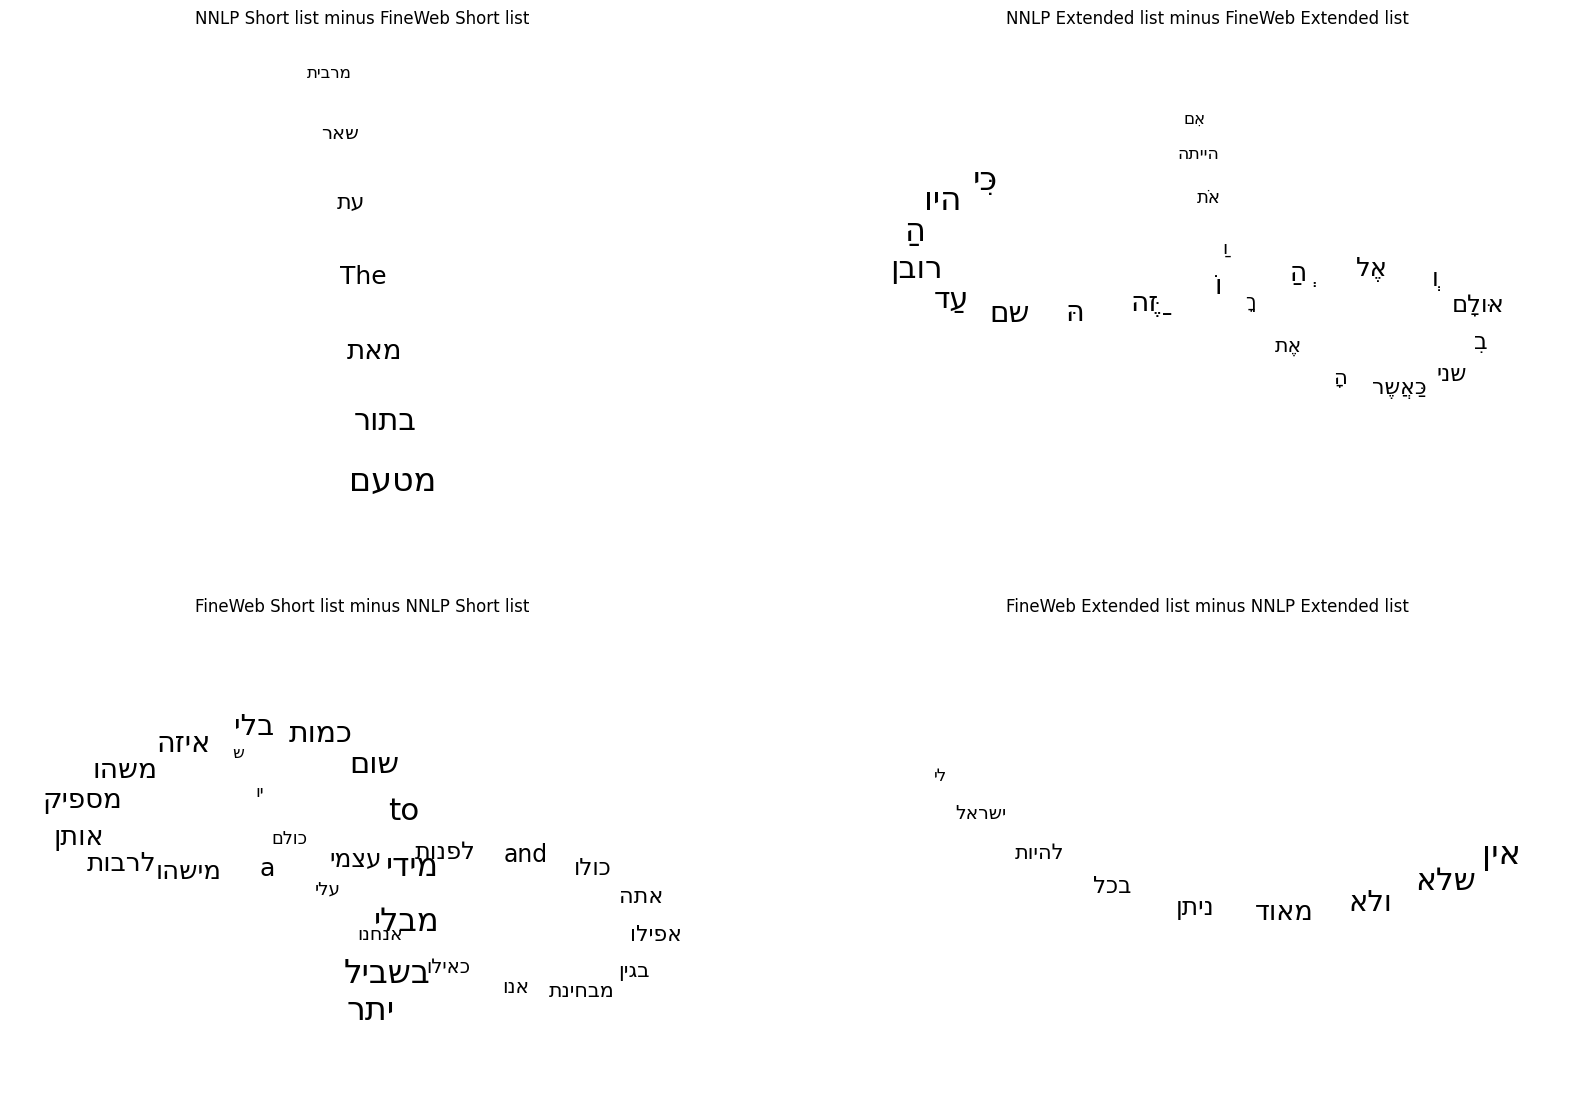

In [9]:
import networkx as nx
from bidi import get_display
from matplotlib import pyplot as plt

def plot_force_directed_layout(ax, words, title=None, seed=42421):
    """
    Plots words using a force-directed layout within a given matplotlib Axes.
    
    Parameters:
        ax (matplotlib.axes.Axes): The matplotlib Axes to draw on.
        words (list or set of str): List of words to display in the force-directed layout.
        title (str, optional): Title for the plot. Default is None.
    """
    words = list(words)
    # Create a random graph structure
    G = nx.Graph()
    for word in words:
        G.add_node(word)
    for i in range(len(words) - 1):
        G.add_edge(words[i], words[i + 1])
    
    positions = nx.spring_layout(G, seed=seed)
    sizes = np.linspace(12, 24, len(words))
    for word, size in zip(words, sizes):
        x, y = positions[word]
        ax.text(x, y, get_display(word), fontsize=size, ha='center', va='center')
    
    if title:
        ax.set_title(title)
    
    ax.set_xlim(-1.2, 1.2)
    ax.set_ylim(-1.2, 1.2)
    ax.axis("off")


def plot_stop_word_differences(simple_token_freq):
    stopwords_base, stopwords_short, stopwords_extend = nnlp_stopword_mining_pipeline(simple_token_freq)
    nnlp_stopwords_short = set(get_nnlp_il_short_stopword_list()['stopswords'].to_list())
    nnlp_stopwords_extended = set(get_nnlp_il_extended_stopword_list()['stopswords'].to_list())
    nnlp_not_in_fineweb_short = nnlp_stopwords_short - stopwords_short
    nnlp_not_in_fineweb_extended = nnlp_stopwords_extended - stopwords_extend
    fineweb_not_in_nnlp_short = stopwords_short - nnlp_stopwords_short
    fineweb_no_in_nnlp_extended = stopwords_extend - nnlp_stopwords_extended
    
    fig, axes = plt.subplots(2, 2, figsize=(20, 14))
    axes = axes.flatten()
    
    titles = ["NNLP Short list minus FineWeb Short list", "NNLP Extended list minus FineWeb Extended list", "FineWeb Short list minus NNLP Short list", "FineWeb Extended list minus NNLP Extended list"]
    sets = [nnlp_not_in_fineweb_short, nnlp_not_in_fineweb_extended, fineweb_not_in_nnlp_short, fineweb_no_in_nnlp_extended]
    for title, word_set, ax in zip(titles, sets, axes):
        plot_force_directed_layout(ax, word_set, title)
    plt.show()

plot_stop_word_differences(simple_token_freq)

#### Upload the Stop-words to the Hub

We upload our mined Stop-word lists to the Huggingface Hub for easier use in future notebook runs.

In [15]:
from datasets import Dataset
def stop_word_gen(stop_words: set):
    for sw in stop_words:
        yield {"stopword": sw}

def make_stop_words_dataset(stop_words: set):
    return Dataset.from_generator(stop_word_gen, gen_kwargs={"stop_words":stop_words})

In [23]:
stopwords_base, stopwords_short, stopwords_extend = nnlp_stopword_mining_pipeline(simple_token_freq)
stopwords_base_ds = make_stop_words_dataset(stopwords_base)
stopwords_short_ds = make_stop_words_dataset(stopwords_short)
stopwords_extended_ds = make_stop_words_dataset(stopwords_extend)
stopwords_base_ds.push_to_hub("guy-or/fineweb2-heb", config_name="base", data_dir="stop_words/base")
stopwords_short_ds.push_to_hub("guy-or/fineweb2-heb", config_name="short", data_dir="stop_words/short")
stopwords_extended_ds.push_to_hub("guy-or/fineweb2-heb", config_name="extended", data_dir="stop_words/extended")

Uploading the dataset shards:   0%|          | 0/1 [00:00<?, ?it/s]

Creating parquet from Arrow format:   0%|          | 0/1 [00:00<?, ?ba/s]

README.md:   0%|          | 0.00/1.11k [00:00<?, ?B/s]

Uploading the dataset shards:   0%|          | 0/1 [00:00<?, ?it/s]

Creating parquet from Arrow format:   0%|          | 0/1 [00:00<?, ?ba/s]

Uploading the dataset shards:   0%|          | 0/1 [00:00<?, ?it/s]

Creating parquet from Arrow format:   0%|          | 0/1 [00:00<?, ?ba/s]

README.md:   0%|          | 0.00/1.12k [00:00<?, ?B/s]

CommitInfo(commit_url='https://huggingface.co/datasets/guy-or/fineweb2-heb/commit/ed273fe4850350256f578f04411839089be45c1c', commit_message='Upload dataset', commit_description='', oid='ed273fe4850350256f578f04411839089be45c1c', pr_url=None, repo_url=RepoUrl('https://huggingface.co/datasets/guy-or/fineweb2-heb', endpoint='https://huggingface.co', repo_type='dataset', repo_id='guy-or/fineweb2-heb'), pr_revision=None, pr_num=None)

## Topic Analysis and Clustering

In this section we will explore methods for unsupervised analysis and visualization of the contents of the documents in our dataset.

The first method that we will employ is *Latent Dirichlet Allocation* (LDA) an unsupervised method for Topic Modelling. LDA is a statistical model which aims to discover hidden "topics" within a collection of documents. Essentially, LDA assumes that documents are mixtures of topics, and topics are mixtures of words. It then works to reverse engineer this process, identifying which topics are present in each document, and which words are associated with each topic. We will utilize *Coherence Measures* (Michael Röder et al) to evaluate the quality of our model and the *pyLDAviz* package to visualize our document clusters.

A second method we will explore is computing Word and Document Embeddings using the *Word2Vec* and *TF-IDF* algorithms. Word embeddings are vector representations of words, where each word is mapped to a point in a high-dimensional space. These vectors capture semantic relationships between words, such that words with similar meanings are located closer to each other in the vector space. This allows machine learning models to understand the context and meaning of words, rather than treating them as isolated symbols. We will leverage these word embeddings to create document embeddings - which are similarily a vector representation of whole documents rather than words.

We will employ PCA for dimensionality reduction of our document embeddings and t-SNE for visually clustering them.

On the implementation side we will utilize the *Gensim* and *Tokenizers* libraries amongst others.


### Training a Tokenizer using Byte Pair Encoding

All the algorithms which we will use to learn the latent features of our documents rely on numerical vector representations of our documents.
For this purpose we need to create a tokenizer that will encode the words in our documents as sequences of integer ids as a first step.

We leverage the Huggingface Tokenizers library and the Byte Pair Encoding algorithm to learn a vocabulary from our dataset. BPE is a subword tokenization learning algorithm which is used in many Transformers models like GPT, BART and RoBERTa and works by constructing a vocabulary of the most common subwords in the training corpus.

We will train the BPE algorithm using our *FineWeb 2* 🥂 sample. We will set the vocabulary size hyperparamter of the algorithm to 33K, following the decision of the researchers behind the Dicta-LM 2.0 Hebew LLM, which also uses a BPE tokenizer. While the researchers at DICTA simply extended the Mistral tokenizer with 1000 Hebrew words, we will learn the vocabulary only from our corpus.

We use byte-level pre-tokenization (splitting on byte boundaries), this has the added advantage of starting with a small 256 characters as the initial alphabet and no need for an "Unknown" token. 

In [152]:
from transformers import AutoTokenizer

dicta_lm_tok = AutoTokenizer.from_pretrained("dicta-il/dictalm2.0")
DICTA_VOCAB_SIZE = dicta_lm_tok.vocab_size
DICTA_VOCAB_SIZE

33152

In [8]:
%%time 
import pyarrow.parquet as pq
from tokenizers import Tokenizer, decoders, normalizers, pre_tokenizers, trainers
from tokenizers.models import BPE

def get_initial_tokenizer_and_trainer(vocab_size):
    tokenizer = Tokenizer(BPE())
    tokenizer.normalizer = normalizers.NFKC()
    tokenizer.pre_tokenizer = pre_tokenizers.ByteLevel()
    tokenizer.decoder = decoders.ByteLevel()
    trainer = trainers.BpeTrainer(vocab_size=vocab_size,)
    return trainer, tokenizer

def get_dataset_len(pq_filepath):
    return pl.scan_parquet(pq_filepath).select(pl.len()).collect().item()

def parquet_file_batch_iterator(pq_corpus_file):
    parquet_file = pq.ParquetFile(pq_corpus_file)
    dataset_len = get_dataset_len(pq_corpus_file)
    with tqdm(total=dataset_len, desc="Processing Chunks", unit="rows") as pbar:
        for batch in parquet_file.iter_batches(columns=['text']):
            yield batch['text'].to_pylist()
            pbar.update(len(batch['text']))

def train_bpe_tokenizer(pq_corpus_file, vocab_size):
    trainer, tokenizer = get_initial_tokenizer_and_trainer(vocab_size)
    tokenizer.train_from_iterator(parquet_file_batch_iterator(pq_corpus_file), trainer=trainer)
    return tokenizer
    

CPU times: user 11.6 ms, sys: 2.19 ms, total: 13.8 ms
Wall time: 24.6 ms


In [ ]:
tokenizer = train_bpe_tokenizer(FINE_WEB_2_HEB_SAMPLE_0_PATH, DICTA_VOCAB_SIZE)
tokenizer.vocab_size

#### Using the Huggingface Hub to store our tokenizer

##### Uploading the tokenizer to the Hub
We will upload the trained tokenizer to the hub to save run time on subsequent runs

In [ ]:
from transformers import PreTrainedTokenizerFast

fast_tokenizer = PreTrainedTokenizerFast(tokenizer_object=tokenizer)
fast_tokenizer.push_to_hub("guy-or/bpe-tokenizer-33k-fineweb2-heb")

##### Loading the tokenizer from the Hub

We load our trained tokenizer from the Hub.
The `encode` and `decode` methods allow us to convert plain text into token ids and back to text.

We can see that the merge rules learned by the tokenizer at the chosen vocabulary length, encode the sentence "סדנה במדעי הנתונים" ("Data science workshop") into 4 token ids.

In [1]:
from transformers import AutoTokenizer

tokenizer = AutoTokenizer.from_pretrained("guy-or/bpe-tokenizer-33k-fineweb2-heb")

In [2]:
tokenizer.encode("סדנה במדעי הנתונים")

[1369, 5683, 18034, 4089]

In [3]:
tokenizer.decode([1369, 5683, 18034, 4089])

'סדנה במדעי הנתונים'

### Topic Modelling using Latent Dirichlet Allocation

After training the tokenizer we are ready to execute our LDA training pipeline.

Our pipeline consists of several steps:
1) Normalization and Stop-word removal which de-noises the data and helps LDA to converge to more meaningful results
2) Tokenization which converts the documents into sequences of token ids
3) Train-Test split which is required for some computing some Coherency Measures which reply on a Reference Corpus (the test split)
4) Creating a sparse Bag-of-Words (BOW) representation of each document in the corpus - this is the required input to our LDA model
5) Iterative training of LDA models with different topic counts along with Coherence evaluation which is used to evaluate each trained model to find the best topic count and track convergence.
6) Visualization using `pyLDAviz` 

#### 1. Normalization and Stop-word Removal

The first step of the pipeline is normalization and stop-word removal.

For normalization I employ a 3-step sequence that consists of:
1) Transforming the text with the [standard Unicode NFKC normalization algorithm](https://unicode.org/reports/tr15/). This algorithm replaces specialized unicode character forms into more generic ones aimed at maximizing compatibility.
2) Applying Huggingface's `BertNormalizer` [algorithm](https://huggingface.co/docs/tokenizers/v0.20.3/en/api/normalizers#tokenizers.normalizers.BertNormalizer) which replaces whitespace sequences with a single space character, strips accents (aka UNICODE Combining Accents) and lower-cases English text.
3) Removing any punctuation characters - This step is important in the context of LDA because if left in the text, punctuation characters would be treated by LDA just as any word, skewing the algorithm's results by potentially considering punctuation as meaningful words inside the learned topics.

In order to remove stop-words we apply the following processing:
1) Call the Huggingface's `BertPreTokenizer` class which splits each document along whitespace sequences and punctuation characters (already replaced by whitespace in the normalization step) into a list.
2) Filter any stop words by using our mined stop-word list.
3) Re-join the string with single space separator between words.

After this process, the filtered corpus is uploaded to the Hub for caching future notebook runs.

In [70]:
from datasets import Dataset, load_dataset
from tokenizers.pre_tokenizers import BertPreTokenizer
import tokenizers.normalizers
import tokenizers
import os

def remove_stopwords_and_punctuation_batched(batch, stopwords):
    """
    Removes stopwords and punctuation from a batch of text examples.

    Args:
        batch (dict): A dictionary containing a list of 'text' fields.
        stopwords (set): A set of stop words.

    Returns:
        dict: The updated batch with stopwords removed.
    """
    texts = batch['text']
    processed_texts = []
    normalizer = normalizers.Sequence([normalizers.NFKC(),
                                       normalizers.BertNormalizer(strip_accents=True),
                                       normalizers.Replace(tokenizers.Regex(r'\p{P}'), ' ')])
    pretokenizer = BertPreTokenizer()

    for text in texts:
        tokens = pretokenizer.pre_tokenize_str(normalizer.normalize_str(text))
        filtered_tokens = [token for token, _ in tokens if token not in stopwords]
        processed_texts.append(" ".join(filtered_tokens))

    return {'text': processed_texts}

def process_dataset_remove_stop_words(ds, stopwords):
    """
    Processes the dataset to remove stopwords.

    Args:
        ds (datasets.Dataset): The input dataset.
        stopwords (set): A set of stop words.

    Returns:
        Dataset: The dataset with stopwords removed.
    """

    num_proc = os.cpu_count() // 2
    return ds.map(
        remove_stopwords_and_punctuation_batched,
        fn_kwargs={"stopwords": stopwords},
        num_proc=num_proc,
        batched=True,
        batch_size=2000,
        desc="Removing stopwords",
    )

In [ ]:
%%time

stopwords_extended = load_dataset("guy-or/fineweb2-heb", "extended")
stopwords_extended_set = set(stopwords_extended['train']['stopword'])
fineweb_heb_ds = Dataset.from_parquet(FINE_WEB_2_HEB_SAMPLE_0_PATH, columns=['id', 'text'], cache_dir="/media/guy/Extreme SSD/huggingface")
fineweb_heb_ds_normalized = process_dataset_remove_stop_words(fineweb_heb_ds, stopwords_extended_set)

##### Uploading to the Hub

In [ ]:
fineweb_heb_ds_normalized.push_to_hub("guy-or/fineweb2-heb", config_name="part_0_stop_words_removed", data_dir="preprocessing/part_0_stop_words_removed")

#### 2. Tokenizing

We use our trained BPE tokenizer to tokenize the corpus after stop-word removal and store the result in the Hub.

In [ ]:
%%time
from datasets import Dataset, load_dataset
import os

def tokenize_fn(examples, tokenizer=None):
    return {"input_ids": tokenizer(examples['text'])["input_ids"]}

def tokenize_dataset(ds, tokenizer):
    num_proc = os.cpu_count() // 2
    return ds.map(
        tokenize_fn,
        fn_kwargs={"tokenizer": tokenizer},
        num_proc=num_proc,
        batched=True,
        batch_size=2000,
        remove_columns=["text"],
        desc="Tokenizing"
    )


In [ ]:
%%time
from transformers import AutoTokenizer

tokenizer = AutoTokenizer.from_pretrained("guy-or/bpe-tokenizer-33k-fineweb2-heb")
fineweb_heb_ds_normalized = load_dataset("guy-or/fineweb2-heb", "part_0_stop_words_removed", cache_dir="/media/guy/Extreme SSD/huggingface")
fineweb_heb_ds_tokenized = tokenize_dataset(fineweb_heb_ds_normalized, tokenizer)

##### Uploading to the Hub

In [ ]:
fineweb_heb_ds_tokenized.push_to_hub("guy-or/fineweb2-heb", config_name="part_0_tokenized", data_dir="preprocessing/part_0_tokenized")

#### 3. Creating a Train-Test split

We create a Train-Test split with test size equal to 10% of our documents. The train split will be used to train the LDA models while the test split will be used as a Reference Corpus for our coherence measures.

The huggingface `train_test_split` also shuffles the dataset so that we reduce the chance of topic-drift between subsequent batches in our training split. This is important for our Online LDA training protocol as each document in the training split will only be seen once by the algorithm due to compute and time constraints.    

In [5]:
from datasets import load_dataset

fineweb_heb_ds_tokenized = load_dataset("guy-or/fineweb2-heb", "part_0_tokenized", cache_dir="/media/guy/Extreme SSD/huggingface")
fineweb_heb_ds_tokenized_split = fineweb_heb_ds_tokenized['train'].train_test_split(seed=42, test_size=0.1)
fineweb_heb_ds_tokenized_train = fineweb_heb_ds_tokenized_split['train']
fineweb_heb_ds_tokenized_test = fineweb_heb_ds_tokenized_split['test']
fineweb_heb_ds_tokenized_split

DatasetDict({
    train: Dataset({
        features: ['id', 'input_ids'],
        num_rows: 2402100
    })
    test: Dataset({
        features: ['id', 'input_ids'],
        num_rows: 266900
    })
})

#### 4. Creating Bag of Words sparse matrices

Once we've tokenized our corpus, we now create a sparse matrices contating the Bag-of-Words representation of each pre-processed document in the corpus.
Each row represents a document and each column corresponds to a token id, this is the input required by our LDA algorithm.

We split the documents into multiple matrices of 50K doucments in order to avoid out of memory issues and save to disk each chunk.

In [27]:
from datasets import IterableDataset, Dataset
from collections import Counter
import scipy.sparse as sparse
import numpy as np
from typing import Iterator
from tqdm.notebook import tqdm

def create_sparse_bow_generator(dataset: IterableDataset, vocab_size: int) -> Iterator[sparse.csr_array]:
    """
    Generates sparse BoW vectors (csr_array) for each example.
    
    Args:
        dataset: IterableDataset with 'input_ids'.
        vocab_size: Vocabulary size.
    
    Yields:
        sparse.csr_array BoW vectors.
    """
    for example in dataset:
        counts = Counter(example['input_ids'])
        indices = list(counts.keys())
        data = list(counts.values())
        yield sparse.csr_array((data, (np.zeros(len(indices)), indices)), shape=(1, vocab_size))


def batch_sparse_bow_vectors(bow_generator: Iterator[sparse.csr_array], batch_size: int, ds_len: int) -> Iterator[sparse.csr_array]:
    """
    Batches sparse BoW vectors from a generator.
    
    Args:
        bow_generator: Generator yielding csr_array vectors.
        batch_size: Batch size.
    
    Yields:
        Batched sparse matrices (csr_array).
    """
    batch = []
    update_every = batch_size // 10
    with tqdm(total=ds_len, desc="Creating sparse BoW vectors", unit="rows") as pbar:
        for bow_vector in bow_generator:
            batch.append(bow_vector)
            len_batch = len(batch)
            if len_batch % update_every == 0:
                pbar.update(update_every)
            if len_batch == batch_size:
                yield sparse.vstack(batch)
                batch = []
        if batch:
            pbar.update(len(batch))
            yield sparse.vstack(batch)

def create_bow_matrix(dataset: Dataset, vocab_size: int, batch_size: int, file_template: str) -> sparse.csr_array:
    """Creates the final BoW matrix."""
    iterable_ds = dataset.to_iterable_dataset()
    ds_len = len(dataset)
    bow_gen = create_sparse_bow_generator(iterable_ds, vocab_size)
    batched_gen = batch_sparse_bow_vectors(bow_gen, batch_size, ds_len)
    for i, matrix in enumerate(batched_gen):
        sparse.save_npz(f"{file_template}_{i:03}", matrix)

In [28]:
%%time
import os

os.makedirs("/media/guy/Extreme SSD/sparse_train", exist_ok=True)
bow_matrix_train = create_bow_matrix(fineweb_heb_ds_tokenized_train, tokenizer.vocab_size, 50000, "/media/guy/Extreme SSD/sparse_train/sparse_bow_matrix")

os.makedirs("/media/guy/Extreme SSD/sparse_test", exist_ok=True)
bow_matrix_test = create_bow_matrix(fineweb_heb_ds_tokenized_test, tokenizer.vocab_size, 50000, "/media/guy/Extreme SSD/sparse_test/sparse_bow_matrix")

Creating sparse BoW vectors:   0%|          | 0/2402100 [00:00<?, ?rows/s]

Creating sparse BoW vectors:   0%|          | 0/266900 [00:00<?, ?rows/s]

CPU times: user 20min 53s, sys: 2.88 s, total: 20min 56s
Wall time: 20min 56s


#### Training LDA models

A common issue with training LDA models is choosing the topic count hyper-parameter. Since our corpus is large and diverse we assume 100 topics are required at minimum to avoid too large topic clusters, this assumption is based on experiments featured on the Gensim package documentation on datasets of similar scale.

We try several topic sizes - 100, 250 and 500 as a means to explore the differences in the final clustering. Trying to find an optimal topic count is highly task-specific, dataset-specific and dependends on other factors such as the Coherence methods used (if any). Since we are interested more in an unsupervised visualization of our data, and since our dataset is large and our compute resources limited, we find this experiment satisfactory.   

For each topic size a separate LDA model is trained. Our LDA training protocol consists of loading each of the 50K sparse Bag-of-Words matrices created in the previous step, zeroing all counts of common ascii punctuation tokens in the BoW vectors (we've found these tokens to be prevalent and throw off the convergence of our topics) and updating the weights of the model every 7K examples (minibatch size). We go through the corpus only once (a single training epoch) due to the large size of the dataset.

For evaluation we use the $C_v$ Indirect Coherence Measure with a window size equalling to 110 which is the default of Gensim. We chose the $C_v$ measure because of its popularity in practice and reported tendency to correlate with human interpretability. In theory other measures could be used as well. Oweing to a lack of clear academic work or best practices, we decided that trying to stochastically optimize the window size would be too much out of scope, time and budget and therefore we stick to the sane defaults provided by the gensim library.  

In [1]:
import os
from gensim.models.ldamulticore import LdaMulticore
from gensim.matutils import Sparse2Corpus
from gensim.models.coherencemodel import CoherenceModel
import scipy.sparse as sparse
from tqdm.notebook import tqdm
import logging
from string import punctuation
from collections import namedtuple

DuckTypeDictionary = namedtuple("DuckTypeDictionary", ["id2token", "token2id"])
# logging.basicConfig(format='%(asctime)s : %(levelname)s : %(message)s', level=logging.INFO)

def generate_id2word(tokenizer):
    return { tid: tokenizer.decode([tid]) for tid in tokenizer.get_vocab().values()}

def get_punctuation_token_ids(tokenizer, stopwords):
    # Assumes that each punctuation character is encoded as a single token in the vocabulary which holds for our trained tokenizer.
    single_punct_tokens = [tokenizer([punct])['input_ids'][0][0] for punct in punctuation]
    # Remove any tokens that consists of spaces and a single non space character or a stopword 
    id2word = generate_id2word(tokenizer)
    length_1_toks = list(
        map(lambda tid_tok: tid_tok[0],
            filter(lambda tid_tok: len(tid_tok[1].strip()) == 1 or tid_tok[1].strip() in stopwords,
                   id2word.items()
                  )
           )
    )
    # Some some space+punct merge rules have been learned as a single token, get these as well
    # space_plus_punct_tokens = [tok[0] for tok in filter(lambda tok: len(tok)==1, [tokenizer([f" {punct}"])['input_ids'][0] for punct in punctuation])]
    # other_tokens = [tokenizer.encode(t)[0] for t in [" ”", "”"," –","–"," "] ]
    return sorted(set(single_punct_tokens + length_1_toks))

def iterate_sparse_arrays_from_folder(input_data_dir: str, punctuation_token_ids, limit_files=None):
    files = list(filter(lambda f: f.endswith(".npz"), os.listdir(input_data_dir)))
    if limit_files is not None:
        files = files[:limit_files]
    with tqdm(total=len(files), desc="Training files", unit="file") as pbar:
        for f in files:
            # Load the BoW matrix
            pat = os.path.join(input_data_dir, f)
            csc_mat = sparse.load_npz(pat).tocsc()
            # Zero out the columns which correspond to our targeted set of punctuation tokens
            csc_mat[:, punctuation_token_ids] = 0 
            csc_mat.eliminate_zeros()
            yield csc_mat
            pbar.update(1)

def train_lda_model(num_topics: int, id2word: dict, punctuation_token_ids, input_data_dir: str, coherence_reference_corpus, limit_files: int = None, coherence_interval=5):
    # the worker count affects the update schedule which is calculated as chunksize*workers,
    # since we want to leverage the maximum processing power any cpu running this notebook can utilize, we dynamically set this value and fix the minibatch schedule
    workers = (os.cpu_count() // 2) - 1
    minibatch = 7000
    chunksize = minibatch // workers
    lda_model = LdaMulticore(num_topics=num_topics, id2word=id2word, workers=workers, chunksize=chunksize, passes=1)
    coherence_values = []
    token2id = {tok:tid for tid,tok in id2word.items()}
    dictionary = DuckTypeDictionary(id2word, token2id)
    for i, data in enumerate(iterate_sparse_arrays_from_folder(input_data_dir, punctuation_token_ids, limit_files=limit_files)):
        corpus = Sparse2Corpus(data, documents_columns=False)
        lda_model.update(corpus)
        # Calculate coherance
        if (i + 1) % coherence_interval == 0:
            coherence_model = CoherenceModel(model=lda_model, texts=coherence_reference_corpus, coherence='c_v', dictionary=dictionary)
            coherence_score = coherence_model.get_coherence()
            per_topic_coherence = coherence_model.get_coherence_per_topic()
            agg_coherence = coherence_model.aggregate_measures(per_topic_coherence)
            coherence_values.append([{'iteration': i+1, 'coherence_score':coherence_score, 'per_topic_coherence':per_topic_coherence, 'agg_coherence':agg_coherence}])
            logging.info(f"Iteration {i + 1}: Coherence Score: {coherence_score}")
    return lda_model, coherence_values

In [6]:
%%time
import json
from transformers import AutoTokenizer
from datasets import load_dataset

# We delete the previous tokenizer to avoid some technical issues with forking the python process after using it.
try:
    del tokenizer
except NameError:
    pass
# Prepare the id2word dict, the punctuation tokens and reference corpus
tokenizer = AutoTokenizer.from_pretrained("guy-or/bpe-tokenizer-33k-fineweb2-heb")
id2word = generate_id2word(tokenizer)
stopwords_extended_set = set(load_dataset("guy-or/fineweb2-heb", "extended", split="train")['stopword'])
punctuation_token_ids = get_punctuation_token_ids(tokenizer, stopwords_extended_set)
coherence_reference_corpus = fineweb_heb_ds_tokenized_test.map(
    lambda ex: {"text": tokenizer.decode(ex['input_ids'])},
    remove_columns=['input_ids', 'id'], batched=False, num_proc=7
)['text']
del tokenizer
LDA_MODEL_TOPIC_SIZES_TO_TRAIN = [100, 250, 500]
models = []
coherence_scores = {}
with tqdm(total=3, desc="Training LDA model", unit="model") as pbar:
    for num_topics in LDA_MODEL_TOPIC_SIZES_TO_TRAIN:
        output_dir = f"lda_{num_topics}_bpe"
        os.makedirs(output_dir, exist_ok=True)
        model_output_file = os.path.join(output_dir, f"lda_{num_topics}_bpe.model")
        lda_model, scores = train_lda_model(100, id2word, punctuation_token_ids, 
                                            "/media/guy/Extreme SSD/sparse_train", 
                                            coherence_reference_corpus, coherence_interval=15)
        models.append(lda_model)
        coherence_scores[num_topics] = scores
        output_file_path = os.path.join(f"coherence_scores_{num_topics}.json")
        with open(output_file_path, 'w') as f:
            json.dump(scores, f, indent=4)
        pbar.update(1)

Training LDA model:   0%|          | 0/3 [00:00<?, ?model/s]

Training files:   0%|          | 0/49 [00:00<?, ?file/s]

/home/guy/development/openuni/ds-project/venv/lib/python3.10/site-packages/scipy/sparse/_index.py:151: SparseEfficiencyWarning: Changing the sparsity structure of a csc_matrix is expensive. lil_matrix is more efficient.
  self._set_arrayXarray(i, j, x)
/home/guy/development/openuni/ds-project/venv/lib/python3.10/site-packages/gensim/topic_coherence/direct_confirmation_measure.py:204: RuntimeWarning: divide by zero encountered in scalar divide
  m_lr_i = np.log(numerator / denominator)
/home/guy/development/openuni/ds-project/venv/lib/python3.10/site-packages/gensim/topic_coherence/indirect_confirmation_measure.py:323: RuntimeWarning: invalid value encountered in scalar divide
  return cv1.T.dot(cv2)[0, 0] / (_magnitude(cv1) * _magnitude(cv2))


NameError: name 'output_dir' is not defined

In [ ]:
import os
from gensim.models.ldamulticore import LdaMulticore
from gensim import corpora
from gensim.matutils import Sparse2Corpus
import scipy.sparse as sparse
import pyLDAvis
import pyLDAvis.gensim_models as gensimvis  # Import this

def load_sparse_matrices(input_data_dir, limit_files=None):
    """Loads sparse matrices from a directory."""
    files = [f for f in os.listdir(input_data_dir) if f.endswith(".npz")]
    if limit_files is not None:
        files = files[:limit_files]
    sparse_matrices = []  # Changed to store the matrices
    for f in files:
        pat = os.path.join(input_data_dir, f)
        sparse_matrices.append(sparse.load_npz(pat).tocsc())  # Load as CSC for consistency
    return sparse_matrices

def visualize_lda_model(lda_model, dictionary, input_data_dir, limit_files=None, vis_filepath='lda.html'):
    """Visualizes an LDA model with pyLDAvis, handling sparse matrix input."""

    sparse_matrices = load_sparse_matrices(input_data_dir, limit_files)  # Load all sparse matrices
    gensim_corpus = []

    for sparse_matrix in sparse_matrices:
        corpus_chunk = Sparse2Corpus(sparse_matrix, documents_columns=False)
        for doc in corpus_chunk: # Iterate through each document in the chunk
            gensim_corpus.append(doc) # Append each document to the final corpus

    vis_data = gensimvis.prepare(lda_model, gensim_corpus, dictionary)  # Use the combined corpus
    pyLDAvis.save_html(vis_data, vis_filepath)
    print(f"Visualization saved to {vis_filepath}")

# Example Usage
# Assuming you have:
# lda_model: Your trained LDA model
# id2word: Your Gensim dictionary
# sparse_data_dir: The directory containing your .npz files

# 1. Train your LDA model (as in your previous code)
# 2. After training:
#    visualize_lda_model(lda_model, id2word, sparse_data_dir)

In [15]:
os.makedirs(f"lda_100_bpe", exist_ok=True)

In [16]:
models[0].save("lda_100_bpe/lda_100.model")

In [11]:
import pyLDAvis
pyLDAvis.enable_notebook()


In [12]:
import pyLDAvis.gensim_models as gensimvis
pyLDAvis.display(models[0])

AttributeError: 'LdaMulticore' object has no attribute 'to_json'

In [7]:
models

In [3]:
stopwords_extended_set = set(load_dataset("guy-or/fineweb2-heb", "extended", split="train")['stopword'])
tokenizer = AutoTokenizer.from_pretrained("guy-or/bpe-tokenizer-33k-fineweb2-heb")

tokenizer.decode(get_punctuation_token_ids(tokenizer, stopwords_extended_set))

NameError: name 'load_dataset' is not defined

In [4]:
from transformers import AutoTokenizer
tokenizer = AutoTokenizer.from_pretrained("guy-or/bpe-tokenizer-33k-fineweb2-heb")


In [15]:
from tokenizers.pre_tokenizers import BertPreTokenizer
#BertPreTokenizer()
rawtokenizer.pre_tokenizer.pre_tokenize("פרויקט, מחורבן ומעצבן")

TypeError: argument 'pretok': 'str' object cannot be converted to 'PreTokenizedString'

In [9]:
_, rawtokenizer = get_initial_tokenizer_and_trainer(1)

In [13]:
rawtokenizer = rawtokenizer.from_pretrained("guy-or/bpe-tokenizer-33k-fineweb2-heb")

In [ ]:
rawtokenizer.pre_tokenizer.pre_tokenize_str